## Import the necessary libraries

Some libraries may have the warning messages, please ignore them. These caused by the libraries version conflicts.

In [2]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier  # 添加决策树
from sklearn.neighbors import KNeighborsClassifier  # 添加KNN
from xgboost import XGBClassifier  # 添加XGBoost
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    precision_recall_curve,
    auc,
    f1_score,
    matthews_corrcoef,
    confusion_matrix  # 添加混淆矩阵
)
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier  # 添加决策树
from sklearn.neighbors import KNeighborsClassifier  # 添加KNN
from xgboost import XGBClassifier  # 添加XGBoost
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    precision_recall_curve,
    auc,
    f1_score,
    matthews_corrcoef,
    confusion_matrix  # 添加混淆矩阵
)
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import matplotlib.pyplot as plt

# 加载数据
data = pd.read_csv('./data/raw_data.csv')

# 计算分子指纹
def get_fingerprint(smiles, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits)
        return np.array(fp)
    else:
        return np.zeros(n_bits)

# 应用分子指纹计算
data['fingerprint'] = data['smiles'].apply(lambda x: get_fingerprint(x))

# 分离正负样本
positive_samples = data[data['antibiotic_activity'] == 1]
negative_samples = data[data['antibiotic_activity'] == 0]

# 设置5折交叉验证
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 模型和超参数设置，添加决策树、KNN和XGBoost
models_params = {
    'Logistic Regression': (LogisticRegression(max_iter=1000), {'C': [0.01, 0.1, 1, 10, 100]}),
    'SVM': (SVC(probability=True), {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}), 
    'Random Forest': (RandomForestClassifier(), {'n_estimators': [10, 50, 100], 'max_depth': [None, 10, 20]}),
    'Decision Tree': (DecisionTreeClassifier(), {'max_depth': [None, 5, 10], 'min_samples_split': [2, 5, 10]}),
    'KNN': (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}),
    'XGBoost': (XGBClassifier(use_label_encoder=False, eval_metric='logloss'), {'n_estimators': [50, 100], 'max_depth': [3, 6], 'learning_rate': [0.01, 0.1]})
}

# 存储每折的结果，包括新增的指标
results = {model: {'ROC-AUC': [], 'PRC-AUC': [], 'Accuracy': [], 'F1 Score': [], 'MCC': [], 'Recall': [], 'Precision': [], 
                   'False Positives': [], 'False Positive Rate': []} for model in models_params}

# 存储所有折的详细结果
all_fold_results = []

# 进行5折交叉验证
for fold, (train_index, test_index) in enumerate(kf.split(positive_samples)):
    print(f"Processing fold {fold + 1}")
    positive_train = positive_samples.iloc[train_index]
    positive_test = positive_samples.iloc[test_index]
    
    # 分离负样本
    negative_train, negative_test = train_test_split(negative_samples, test_size=0.2, random_state=fold)
    
    # 对训练集负样本进行聚类选择
    num_clusters_train = 2 * len(positive_train)
    num_clusters_train = min(num_clusters_train, len(negative_train))  # 防止聚类数超过样本数
    num_clusters_train = max(num_clusters_train, 1)  # 至少一个簇
    kmeans_train = KMeans(n_clusters=num_clusters_train, random_state=42)
    negative_train_fingerprints = np.vstack(negative_train['fingerprint'].values)
    kmeans_train.fit(negative_train_fingerprints)
    closest_train, _ = pairwise_distances_argmin_min(kmeans_train.cluster_centers_, negative_train_fingerprints)
    selected_negative_train = negative_train.iloc[closest_train[:num_clusters_train]]
    
    # 对测试集负样本进行聚类选择
    num_clusters_test = 2 * len(positive_test)
    num_clusters_test = min(num_clusters_test, len(negative_test))  # 防止聚类数超过样本数
    num_clusters_test = max(num_clusters_test, 1)  # 至少一个簇
    kmeans_test = KMeans(n_clusters=num_clusters_test, random_state=42)
    negative_test_fingerprints = np.vstack(negative_test['fingerprint'].values)
    kmeans_test.fit(negative_test_fingerprints)
    closest_test, _ = pairwise_distances_argmin_min(kmeans_test.cluster_centers_, negative_test_fingerprints)
    selected_negative_test = negative_test.iloc[closest_test[:num_clusters_test]]
    
    # 合并训练和测试数据集
    train_data = pd.concat([positive_train, selected_negative_train])
    test_data = pd.concat([positive_test, selected_negative_test])
    
    # 准备训练和测试数据
    X_train = np.vstack(train_data['fingerprint'].values)
    y_train = train_data['antibiotic_activity'].values
    X_test = np.vstack(test_data['fingerprint'].values)
    y_test = test_data['antibiotic_activity'].values
    
    # 特征缩放
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 对每个模型进行训练和评估
    for model_name, (model, params) in models_params.items():
        clf = GridSearchCV(model, params, scoring='roc_auc', cv=5)
        clf.fit(X_train_scaled, y_train)
        best_model = clf.best_estimator_
        y_pred = best_model.predict(X_test_scaled)
        
        # 处理预测概率
        if hasattr(best_model, "predict_proba"):
            y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
        else:
            # 对于不支持 predict_proba 的模型，如某些 SVM
            y_pred_proba = best_model.decision_function(X_test_scaled)
            # 将决策函数输出归一化到 [0,1]
            y_pred_proba = (y_pred_proba - y_pred_proba.min()) / (y_pred_proba.max() - y_pred_proba.min()) if y_pred_proba.max() != y_pred_proba.min() else np.zeros_like(y_pred_proba)
        
        # 计算性能指标
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        prc_auc = auc(recall, precision)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        mcc = matthews_corrcoef(y_test, y_pred)
        recall_value = recall_score(y_test, y_pred)
        precision_score_value = precision_score(y_test, y_pred)
        # 计算混淆矩阵
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        fp_rate = fp / (fp + tn) if (fp + tn) > 0 else 0

        # 存储结果
        results[model_name]['ROC-AUC'].append(roc_auc)
        results[model_name]['PRC-AUC'].append(prc_auc)
        results[model_name]['Accuracy'].append(accuracy)
        results[model_name]['F1 Score'].append(f1)
        results[model_name]['MCC'].append(mcc)
        results[model_name]['Precision'].append(precision_score_value)
        results[model_name]['Recall'].append(recall_value)
        results[model_name]['False Positives'].append(fp)
        results[model_name]['False Positive Rate'].append(fp_rate)
        
        # 存储每折每个模型的详细结果
        fold_result = {
            'Fold': fold + 1,
            'Model': model_name,
            'ROC-AUC': roc_auc,
            'PRC-AUC': prc_auc,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'MCC': mcc,
            'Recall': recall_value,
            'Precision': precision_score_value,
            'False Positives': fp,
            'False Positive Rate': fp_rate
        }
        all_fold_results.append(fold_result)

# 将所有折的结果保存为DataFrame
# fold_results_df = pd.DataFrame(all_fold_results)
# 保存到CSV文件
# fold_results_df.to_csv('model_evaluation_per_fold.csv', index=False)




[22:47:53] DEPRECATION WARNING: please use MorganGenerator
[22:47:53] DEPRECATION WARNING: please use MorganGenerator
[22:47:53] DEPRECATION WARNING: please use MorganGenerator
[22:47:53] DEPRECATION WARNING: please use MorganGenerator
[22:47:53] DEPRECATION WARNING: please use MorganGenerator
[22:47:53] DEPRECATION WARNING: please use MorganGenerator
[22:47:53] DEPRECATION WARNING: please use MorganGenerator
[22:47:53] DEPRECATION WARNING: please use MorganGenerator
[22:47:53] DEPRECATION WARNING: please use MorganGenerator
[22:47:53] DEPRECATION WARNING: please use MorganGenerator
[22:47:53] DEPRECATION WARNING: please use MorganGenerator
[22:47:53] DEPRECATION WARNING: please use MorganGenerator
[22:47:53] DEPRECATION WARNING: please use MorganGenerator
[22:47:53] DEPRECATION WARNING: please use MorganGenerator
[22:47:53] DEPRECATION WARNING: please use MorganGenerator
[22:47:53] DEPRECATION WARNING: please use MorganGenerator
[22:47:53] DEPRECATION WARNING: please use MorganGenerat

Processing fold 1


c:\Users\dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:49:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:49:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:49:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:49:26] WARNING: C:\actions-r

Processing fold 2


c:\Users\dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:51:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:51:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:51:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:51:02] WARNING: C:\actions-r

Processing fold 3


c:\Users\dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:52:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:52:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:52:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:52:28] WARNING: C:\actions-r

Processing fold 4


c:\Users\dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:53:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:53:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:53:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:53:52] WARNING: C:\actions-r

Processing fold 5


c:\Users\dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:55:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:55:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:55:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:55:21] WARNING: C:\actions-r

Model Performance Metrics (Mean ± Std):
                                                        ROC-AUC  \
Logistic Regression  (0.8503734721593481, 0.027289001899861186)   
SVM                   (0.8606722498868266, 0.03539785226661406)   
Random Forest         (0.8779085559076505, 0.03617409890845495)   
Decision Tree        (0.7189565414214576, 0.020313624222215613)   
KNN                   (0.7336634223630603, 0.02602415450690767)   
XGBoost              (0.8566942055228608, 0.029765201803988898)   

                                                        PRC-AUC  \
Logistic Regression  (0.7471921426780763, 0.056897551870738444)   
SVM                     (0.77525512660533, 0.05800712303707247)   
Random Forest        (0.7998930804091651, 0.059396268491029115)   
Decision Tree        (0.6803591941558241, 0.020428005865219312)   
KNN                  (0.7202505777880482, 0.044604176781843884)   
XGBoost              (0.7685614468632608, 0.053383832166105226)   

                    

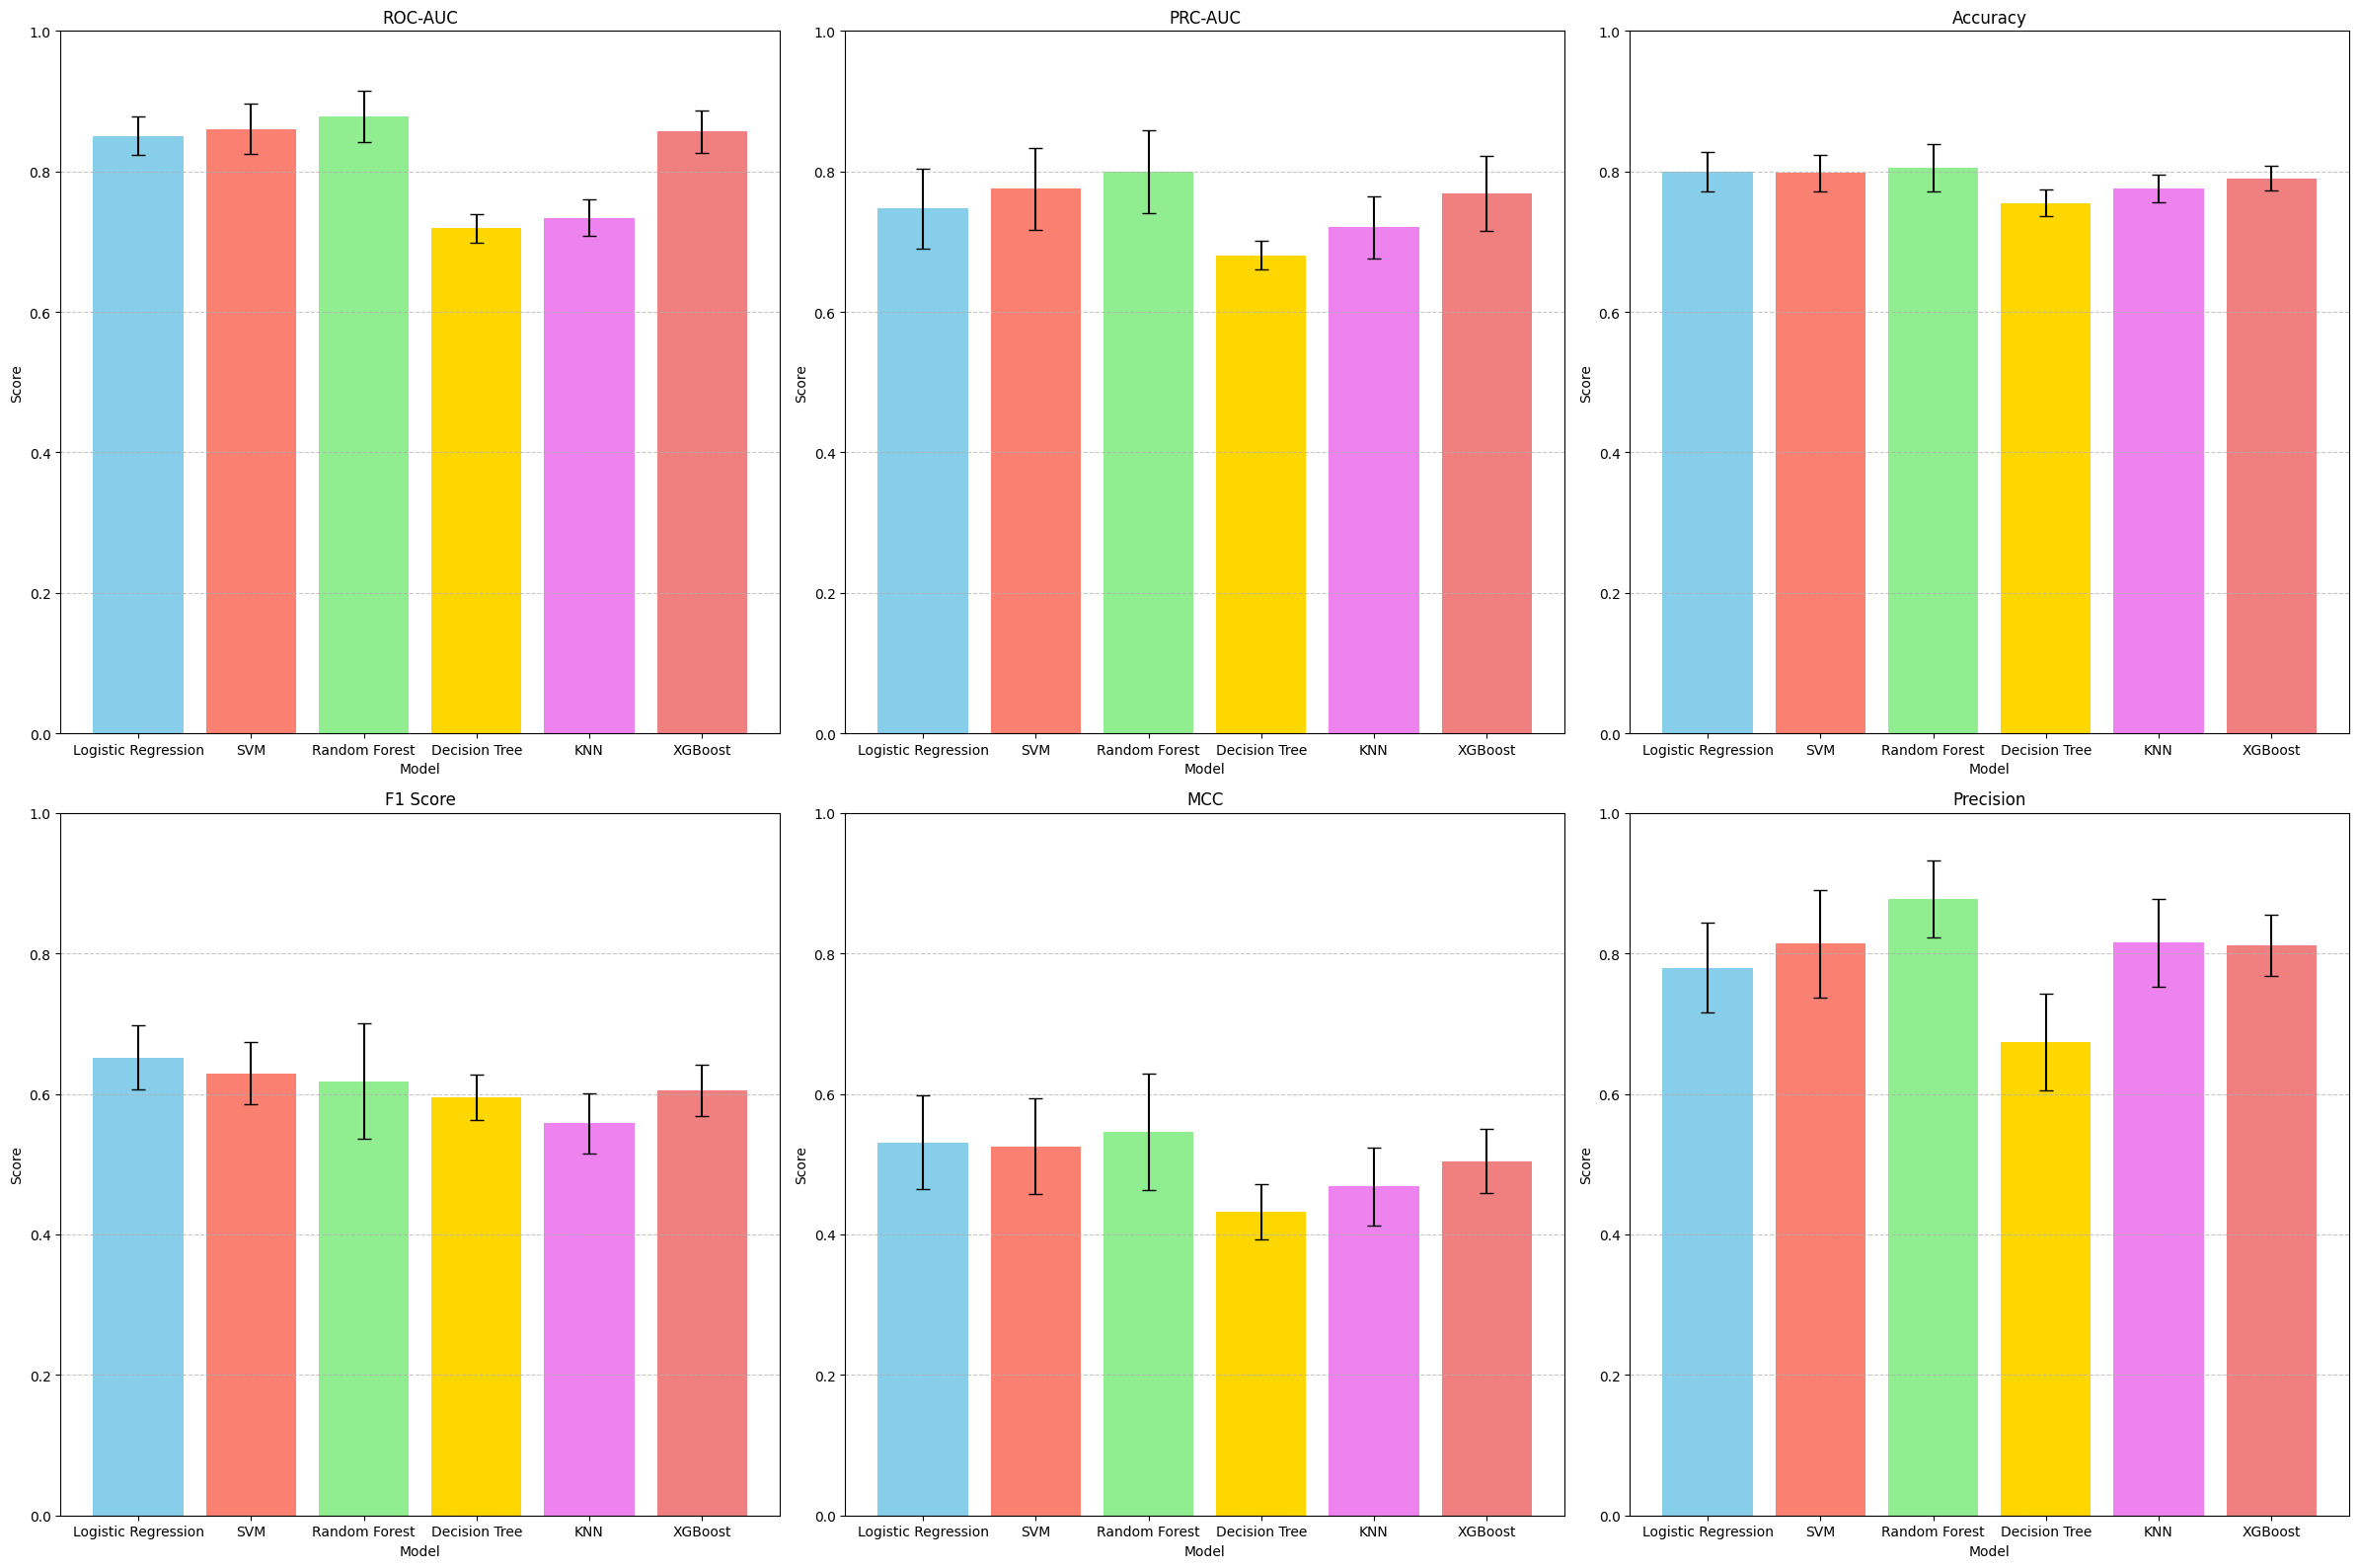

In [7]:
# 计算均值和标准差
mean_std_results = {
    model: {metric: (np.mean(scores), np.std(scores))
            for metric, scores in metrics.items()}
    for model, metrics in results.items()
}

# 打印结果，包括新增的指标
mean_std_df = pd.DataFrame(mean_std_results).T
print("Model Performance Metrics (Mean ± Std):")
print(mean_std_df)

# 绘图，包括新增的指标

metrics_to_plot = ['ROC-AUC', 'PRC-AUC', 'Accuracy', 'F1 Score', 'MCC', 'Precision']
num_metrics = len(metrics_to_plot)
fig, axes = plt.subplots(2, 3, figsize=(24, 16))
axes = axes.ravel()

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    means = [mean_std_results[model][metric][0] for model in models_params]
    stds = [mean_std_results[model][metric][1] for model in models_params]
    ax.bar(models_params.keys(), means, yerr=stds, capsize=5, color=['skyblue', 'salmon', 'lightgreen', 'gold', 'violet', 'lightcoral'])
    ax.set_title(f"{metric}")
    ax.set_xlabel('Model')
    ax.set_ylabel('Score')
    # 针对 False Positive Rate 设置 y 轴范围
    if metric == 'False Positive Rate':
        ax.set_ylim(0, max(means) + max(stds) + 0.05)
    else:
        ax.set_ylim(0, 1)  # 一致的y轴范围，便于比较
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
# plt.savefig('antibiotics_performance.pdf')

[23:21:27] DEPRECATION WARNING: please use MorganGenerator
[23:21:27] DEPRECATION WARNING: please use MorganGenerator
[23:21:27] DEPRECATION WARNING: please use MorganGenerator
[23:21:27] DEPRECATION WARNING: please use MorganGenerator
[23:21:27] DEPRECATION WARNING: please use MorganGenerator
[23:21:27] DEPRECATION WARNING: please use MorganGenerator
[23:21:27] DEPRECATION WARNING: please use MorganGenerator
[23:21:27] DEPRECATION WARNING: please use MorganGenerator
[23:21:27] DEPRECATION WARNING: please use MorganGenerator
[23:21:27] DEPRECATION WARNING: please use MorganGenerator
[23:21:27] DEPRECATION WARNING: please use MorganGenerator
[23:21:27] DEPRECATION WARNING: please use MorganGenerator
[23:21:27] DEPRECATION WARNING: please use MorganGenerator
[23:21:27] DEPRECATION WARNING: please use MorganGenerator
[23:21:27] DEPRECATION WARNING: please use MorganGenerator
[23:21:27] DEPRECATION WARNING: please use MorganGenerator
[23:21:27] DEPRECATION WARNING: please use MorganGenerat

Processing fold 1


c:\Users\dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:23:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Processing fold 2


c:\Users\dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:25:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Processing fold 3


c:\Users\dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:27:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Processing fold 4


c:\Users\dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:29:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Processing fold 5


c:\Users\dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:31:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== Saved ===
- Per-fold CSV: ./ml_outputs\model_evaluation_per_fold.csv
- Summary CSV : ./ml_outputs\summary_mean_sd.csv

Summary (head):
                     InnerCV ROC-AUC (mean) (mean)  \
Decision Tree                             0.658616   
KNN                                       0.654811   
Logistic Regression                       0.753784   
Random Forest                             0.767747   
SVM                                       0.751367   

                     InnerCV ROC-AUC (mean) (std)  
Decision Tree                            0.023926  
KNN                                      0.011857  
Logistic Regression                      0.019512  
Random Forest                            0.025326  
SVM                                      0.021173  


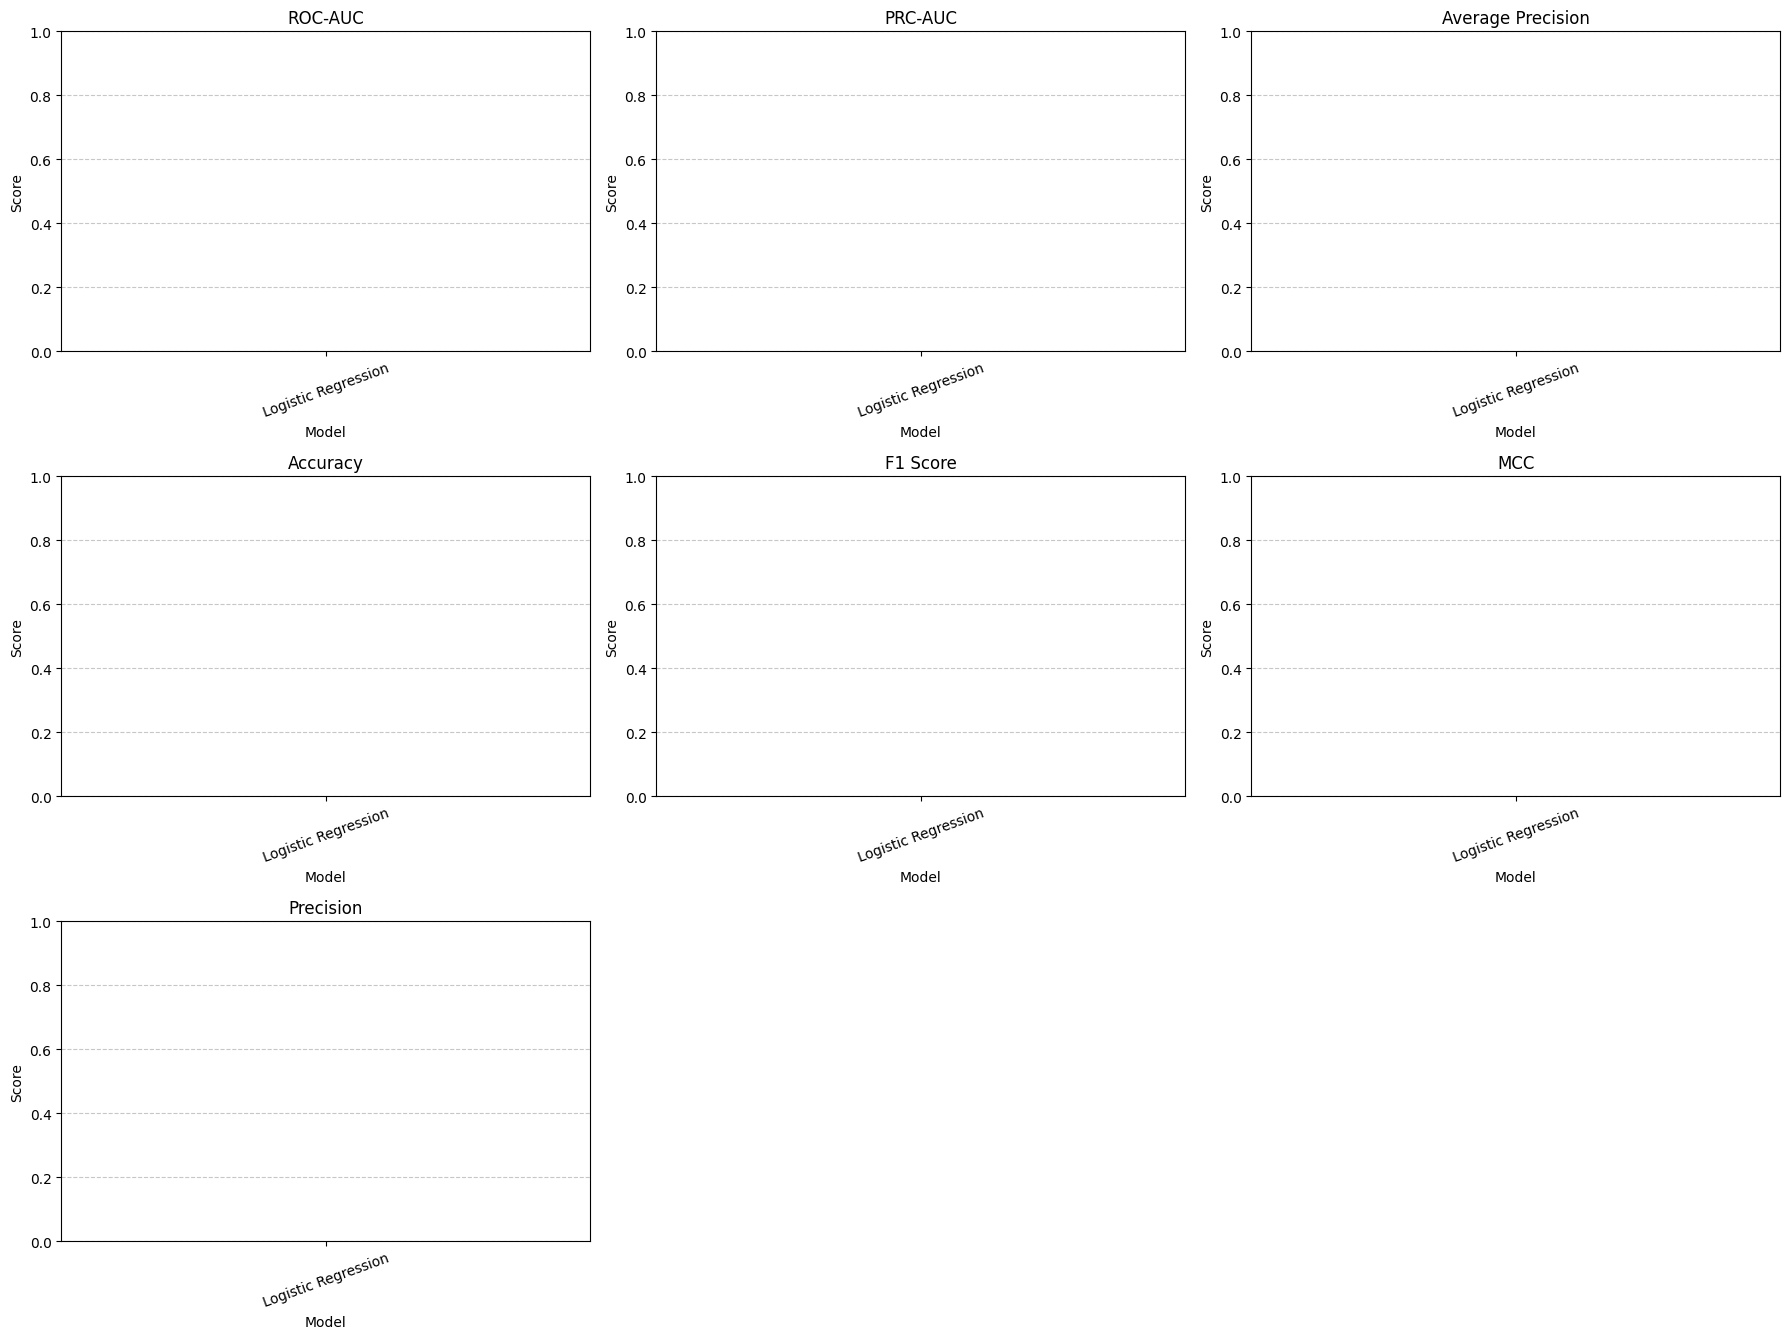

Figure saved to: ./ml_outputs\antibiotics_performance_summary.png


In [ ]:
# -*- coding: utf-8 -*-
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier  # 决策树
from sklearn.neighbors import KNeighborsClassifier  # KNN
from xgboost import XGBClassifier  # XGBoost
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    precision_recall_curve,
    auc,
    f1_score,
    matthews_corrcoef,
    confusion_matrix,
    average_precision_score
)
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

# ---------------------------
# 0) 全局配置
# ---------------------------
SEED = 42
OUTDIR = "./ml_outputs"
os.makedirs(OUTDIR, exist_ok=True)

# 是否绘制汇总条形图
PLOT_SUMMARY = True

# ---------------------------
# 1) 加载数据
# 需要包含两列：'smiles' 与 'antibiotic_activity' (0/1)
# ---------------------------
DATA_CSV = "./data/raw_data.csv"
data = pd.read_csv(DATA_CSV)

assert 'smiles' in data.columns, "raw_data.csv 必须包含列 'smiles'"
assert 'antibiotic_activity' in data.columns, "raw_data.csv 必须包含列 'antibiotic_activity' (0/1)"

# ---------------------------
# 2) 计算分子指纹（ECFP4：Morgan radius=2, 2048-bit, binary）
# ---------------------------
def get_fingerprint(smiles, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits)  # radius=2 ≈ ECFP4
        # 注意：np.array(fp) 在不同版本RDKit下可能直接得到0/1数组，也可能需要转换
        arr = np.zeros((1, n_bits), dtype=np.int8)
        Chem.DataStructs.ConvertToNumpyArray(fp, arr[0])
        return arr[0]
    else:
        return np.zeros(n_bits, dtype=np.int8)

# 应用分子指纹计算
data['fingerprint'] = data['smiles'].apply(get_fingerprint)

# 分离正负样本
positive_samples = data[data['antibiotic_activity'] == 1].reset_index(drop=True)
negative_samples = data[data['antibiotic_activity'] == 0].reset_index(drop=True)

# ---------------------------
# 3) 外层 5 折（保持你原有做法：仅在正样本上分折）
# ---------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

# ---------------------------
# 4) 模型与超参数
# ---------------------------
models_params = {
    'Logistic Regression': (
        LogisticRegression(max_iter=1000),
        {'C': [0.01, 0.1, 1, 10, 100]}
    ),
    'SVM': (
        SVC(probability=True),
        {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
    ),
    'Random Forest': (
        RandomForestClassifier(),
        {'n_estimators': [10, 50, 100], 'max_depth': [None, 10, 20]}
    ),
    'Decision Tree': (
        DecisionTreeClassifier(),
        {'max_depth': [None, 5, 10], 'min_samples_split': [2, 5, 10]}
    ),
    'KNN': (
        KNeighborsClassifier(),
        {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
    ),
    'XGBoost': (
        XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        {'n_estimators': [50, 100], 'max_depth': [3, 6], 'learning_rate': [0.01, 0.1]}
    )
}

# ---------------------------
# 5) 结果容器
# ---------------------------
results = {
    model: {
        'ROC-AUC': [], 'PRC-AUC': [], 'Average Precision': [],
        'Accuracy': [], 'F1 Score': [], 'MCC': [], 'Recall': [], 'Precision': [],
        'False Positives': [], 'False Positive Rate': [],
        'InnerCV ROC-AUC (mean)': [], 'Best Params': []
    } for model in models_params
}
all_fold_results = []

# ---------------------------
# 6) 外层循环（保持你原有的测试集KMeans负样本选择）
# ---------------------------
for fold, (train_index, test_index) in enumerate(kf.split(positive_samples), start=1):
    print(f"Processing fold {fold}")
    positive_train = positive_samples.iloc[train_index]
    positive_test  = positive_samples.iloc[test_index]

    # 分离负样本（与你原来一致）
    negative_train, negative_test = train_test_split(
        negative_samples, test_size=0.2, random_state=fold
    )

    # —— 训练集负样本：KMeans 代表点选择（目标= 2 * len(positive_train)）
    num_clusters_train = 2 * len(positive_train)
    num_clusters_train = min(num_clusters_train, len(negative_train))
    num_clusters_train = max(num_clusters_train, 1)
    kmeans_train = KMeans(n_clusters=num_clusters_train, random_state=SEED)
    negative_train_fingerprints = np.vstack(negative_train['fingerprint'].values)
    kmeans_train.fit(negative_train_fingerprints)
    closest_train, _ = pairwise_distances_argmin_min(
        kmeans_train.cluster_centers_, negative_train_fingerprints
    )
    selected_negative_train = negative_train.iloc[closest_train[:num_clusters_train]]

    # —— 测试集负样本：保持你原有做法（同样KMeans选代表点）
    num_clusters_test = 2 * len(positive_test)
    num_clusters_test = min(num_clusters_test, len(negative_test))
    num_clusters_test = max(num_clusters_test, 1)
    kmeans_test = KMeans(n_clusters=num_clusters_test, random_state=SEED)
    negative_test_fingerprints = np.vstack(negative_test['fingerprint'].values)
    kmeans_test.fit(negative_test_fingerprints)
    closest_test, _ = pairwise_distances_argmin_min(
        kmeans_test.cluster_centers_, negative_test_fingerprints
    )
    selected_negative_test = negative_test.iloc[closest_test[:num_clusters_test]]

    # 合并训练和测试数据集
    train_data = pd.concat([positive_train, selected_negative_train], ignore_index=True)
    test_data  = pd.concat([positive_test,  selected_negative_test],  ignore_index=True)

    # 准备训练和测试数据
    X_train = np.vstack(train_data['fingerprint'].values).astype(np.float32)
    y_train = train_data['antibiotic_activity'].values
    X_test  = np.vstack(test_data['fingerprint'].values).astype(np.float32)
    y_test  = test_data['antibiotic_activity'].values

    # 特征缩放（保持你原始做法：先在外层训练集拟合，再用于内层CV与测试）
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    # —— 针对每个模型做训练与评估
    for model_name, (model, params) in models_params.items():
        # 关键改动：显式给出 refit 指标，并记录内层CV最佳分数/参数
        clf = GridSearchCV(
            estimator=model,
            param_grid=params,
            scoring='roc_auc',   # 以 ROC-AUC 作为选择指标
            refit='roc_auc',     # 用最佳ROC-AUC参数在训练集重拟合
            cv=5,
            n_jobs=-1,
            return_train_score=False
        )
        clf.fit(X_train_scaled, y_train)

        best_model   = clf.best_estimator_
        best_params  = clf.best_params_
        best_cv_roc  = clf.best_score_  # 内层CV的平均ROC-AUC（验证集=外层训练集的5折）

        # —— 测试集预测：概率/分数 + 0/1标签
        y_pred = best_model.predict(X_test_scaled)

        if hasattr(best_model, "predict_proba"):
            y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
        else:
            # 对于不支持 predict_proba 的模型（如某些SVM），使用 decision_function 并单调归一化
            y_pred_proba = best_model.decision_function(X_test_scaled)
            if np.max(y_pred_proba) != np.min(y_pred_proba):
                y_pred_proba = (y_pred_proba - np.min(y_pred_proba)) / (np.max(y_pred_proba) - np.min(y_pred_proba))
            else:
                y_pred_proba = np.zeros_like(y_pred_proba)

        # —— 排名指标
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        precision_vec, recall_vec, _ = precision_recall_curve(y_test, y_pred_proba)
        prc_auc = auc(recall_vec, precision_vec)
        ap = average_precision_score(y_test, y_pred_proba)

        # —— 阈值型指标
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        mcc = matthews_corrcoef(y_test, y_pred)
        recall_value = recall_score(y_test, y_pred)
        precision_score_value = precision_score(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        fp_rate = fp / (fp + tn) if (fp + tn) > 0 else 0.0

        # —— 存储
        results[model_name]['ROC-AUC'].append(roc_auc)
        results[model_name]['PRC-AUC'].append(prc_auc)
        results[model_name]['Average Precision'].append(ap)
        results[model_name]['Accuracy'].append(accuracy)
        results[model_name]['F1 Score'].append(f1)
        results[model_name]['MCC'].append(mcc)
        results[model_name]['Recall'].append(recall_value)
        results[model_name]['Precision'].append(precision_score_value)
        results[model_name]['False Positives'].append(fp)
        results[model_name]['False Positive Rate'].append(fp_rate)
        results[model_name]['InnerCV ROC-AUC (mean)'].append(best_cv_roc)
        results[model_name]['Best Params'].append(best_params)

        # —— 每折详细结果（写CSV）
        fold_result = {
            'Fold': fold,
            'Model': model_name,
            'ROC-AUC': roc_auc,
            'PRC-AUC': prc_auc,
            'Average Precision': ap,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'MCC': mcc,
            'Recall': recall_value,
            'Precision': precision_score_value,
            'TN': int(tn), 'FP': int(fp), 'FN': int(fn), 'TP': int(tp),
            'False Positive Rate': fp_rate,
            'InnerCV ROC-AUC (mean)': best_cv_roc,
            'Best Params': json.dumps(best_params)
        }
        all_fold_results.append(fold_result)

# ---------------------------
# 7) 将所有折的结果保存为CSV
# ---------------------------
per_fold_df = pd.DataFrame(all_fold_results)
per_fold_csv = os.path.join(OUTDIR, 'model_evaluation_per_fold.csv')
per_fold_df.to_csv(per_fold_csv, index=False)

# ---------------------------
# 8) 汇总均值和标准差，并保存
# ---------------------------
mean_std_results = {
    model: {
        metric + " (mean)": float(np.mean(vals)) if len(vals) > 0 else np.nan,
        metric + " (std)":  float(np.std(vals))  if len(vals) > 0 else np.nan
    }
    for model, metrics in results.items()
    for metric, vals in metrics.items()
    if metric not in ['Best Params']  # Best Params 不做统计
}

# 将嵌套dict整理为 DataFrame（行=模型，列=指标mean/std）
summary_df = (
    pd.DataFrame(mean_std_results)
      .T
      .sort_index()
)
summary_csv = os.path.join(OUTDIR, 'summary_mean_sd.csv')
summary_df.to_csv(summary_csv)

print("\n=== Saved ===")
print(f"- Per-fold CSV: {per_fold_csv}")
print(f"- Summary CSV : {summary_csv}")
print("\nSummary (head):")
print(summary_df.head())

# ---------------------------
# 9) 绘图（可选）
# ---------------------------
# if PLOT_SUMMARY:
#     metrics_to_plot = ['ROC-AUC', 'PRC-AUC', 'Average Precision', 'Accuracy', 'F1 Score', 'MCC', 'Precision']
#     num_metrics = len(metrics_to_plot)

#     ncols = 3
#     nrows = (num_metrics + ncols - 1) // ncols
#     fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 4.5*nrows))
#     axes = np.array(axes).reshape(-1)

#     model_names = list(models_params.keys())

#     # 从 summary_df 抽取 mean/std
#     def get_ms(model, metric):
#         m = summary_df.loc[model, metric + " (mean)"] if metric + " (mean)" in summary_df.columns else np.nan
#         s = summary_df.loc[model, metric + " (std)"]  if metric + " (std)"  in summary_df.columns else np.nan
#         return m, s

#     for i, metric in enumerate(metrics_to_plot):
#         ax = axes[i]
#         means, stds = [], []
#         for m in model_names:
#             mean_v, std_v = get_ms(m, metric)
#             means.append(mean_v)
#             stds.append(std_v)
#         ax.bar(model_names, means, yerr=stds, capsize=5)
#         ax.set_title(metric)
#         ax.set_xlabel('Model')
#         ax.set_ylabel('Score')
#         if metric == 'False Positive Rate':
#             ymax = (np.nanmax(np.array(means) + np.array(stds)) if len(means) else 1.0)
#             ax.set_ylim(0, min(1.0, ymax + 0.05))
#         else:
#             ax.set_ylim(0, 1)
#         ax.grid(True, axis='y', linestyle='--', alpha=0.7)
#         ax.tick_params(axis='x', rotation=20)

#     # 清理多余子图
#     for j in range(i+1, len(axes)):
#         axes[j].axis('off')

#     plt.tight_layout()
#     fig_path = os.path.join(OUTDIR, "antibiotics_performance_summary.png")
#     plt.savefig(fig_path, dpi=250)
#     plt.show()
#     print(f"Figure saved to: {fig_path}")


In [4]:
summary_df

InnerCV ROC-AUC (mean) (mean)  \
Decision Tree                             0.658616   
KNN                                       0.654811   
Logistic Regression                       0.753784   
Random Forest                             0.767747   
SVM                                       0.751367   
XGBoost                                   0.747752   

                     InnerCV ROC-AUC (mean) (std)  
Decision Tree                            0.023926  
KNN                                      0.011857  
Logistic Regression                      0.019512  
Random Forest                            0.025326  
SVM                                      0.021173  
XGBoost                                  0.030102

In [10]:
# -*- coding: utf-8 -*-
import os, json, time, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs

from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score,
    precision_recall_curve, auc, f1_score, matthews_corrcoef,
    confusion_matrix, average_precision_score,
    pairwise_distances, pairwise_distances_argmin_min
)

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# =========================
# 0) 全局配置
# =========================
SEED = 42
OUTDIR = "./ml_outputs"
os.makedirs(OUTDIR, exist_ok=True)

DATA_CSV = "./data/raw_data.csv"   # 必含: smiles, antibiotic_activity(0/1)
FINGERPRINT_BITS_LIST = [1024, 2048, 4096]
N_OUTER_FOLDS = 5
INNER_CV_SPLITS = 5
PLOT_SUMMARY = False
warnings.filterwarnings("ignore")

# =========================
# 1) 加载数据
# =========================
data = pd.read_csv(DATA_CSV)
assert 'smiles' in data.columns, "raw_data.csv 必须包含列 'smiles'"
assert 'antibiotic_activity' in data.columns, "raw_data.csv 必须包含列 'antibiotic_activity' (0/1)"

# =========================
# 2) 指纹函数（ECFP4 / radius=2）
# =========================
def fp_morgan_bits(smiles: str, n_bits: int = 2048, radius: int = 2):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(n_bits, dtype=np.int8)
    bv = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=n_bits)
    arr = np.zeros((n_bits,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(bv, arr)
    return arr

# —— 内存友好的最近索引（分块兜底）——
def nearest_indices_chunked(centers: np.ndarray, X: np.ndarray, chunk: int = 4096):
    """
    返回：best_idx, best_dist
    centers: (k, d) float32
    X      : (n, d) float32
    """
    k = centers.shape[0]
    best_idx = np.zeros(k, dtype=np.int64)
    best_dist = np.full(k, np.inf, dtype=np.float64)
    for start in range(0, X.shape[0], chunk):
        block = X[start:start+chunk]
        # (k, chunk) 的二维距离矩阵，内存友好
        D = pairwise_distances(centers, block, metric='euclidean', n_jobs=1)
        idx_min = D.argmin(axis=1)
        dist_min = D[np.arange(k), idx_min]
        better = dist_min < best_dist
        best_dist[better] = dist_min[better]
        best_idx[better] = start + idx_min[better]
    return best_idx, best_dist

# =========================
# 3) 模型与超参网格
# =========================
models_params = {
    'Logistic Regression': (
        LogisticRegression(max_iter=1000, random_state=SEED),  # 注意: 不要传 n_jobs
        {'C': [0.01, 0.1, 1, 10, 100]}
    ),
    'SVM': (
        SVC(probability=True, random_state=SEED),
        {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
    ),
    'Random Forest': (
        RandomForestClassifier(random_state=SEED, n_jobs=-1),
        {'n_estimators': [100, 300], 'max_depth': [None, 10, 20]}
    ),
    'Decision Tree': (
        DecisionTreeClassifier(random_state=SEED),
        {'max_depth': [None, 5, 10], 'min_samples_split': [2, 5, 10]}
    ),
    'KNN': (
        KNeighborsClassifier(),
        {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
    ),
    'XGBoost': (
        XGBClassifier(
            use_label_encoder=False,
            eval_metric='logloss',
            tree_method='hist',
            random_state=SEED,
            n_jobs=-1
        ),
        {'n_estimators': [200, 400], 'max_depth': [3, 6], 'learning_rate': [0.03, 0.1]}
    )
}

# =========================
# 4) 结果容器
# =========================
all_fold_rows = []
all_summ_rows = []
time_logs = []

positive_all = data[data['antibiotic_activity'] == 1].reset_index(drop=True)
negative_all = data[data['antibiotic_activity'] == 0].reset_index(drop=True)

outer_kf = KFold(n_splits=N_OUTER_FOLDS, shuffle=True, random_state=SEED)

# =========================
# 5) 主循环：不同指纹长度
# =========================
for FP_BITS in FINGERPRINT_BITS_LIST:
    print(f"\n=== Running with ECFP4 bits = {FP_BITS} ===")
    # 5.1 预生成指纹
    t0 = time.time()
    fps = np.vstack([fp_morgan_bits(s, n_bits=FP_BITS, radius=2) for s in data['smiles']]).astype(np.float32)
    t_fp = time.time() - t0
    density = float(fps.mean())  # 置位率（稀疏度指标）
    print(f"[Info] FP gen {FP_BITS}-bit: {t_fp:.2f}s, density={density:.6f}")

    fold_id = 0
    for tr_pos_idx, te_pos_idx in outer_kf.split(positive_all):
        fold_id += 1
        print(f"  > Fold {fold_id}")

        positive_train = positive_all.iloc[tr_pos_idx]
        positive_test  = positive_all.iloc[te_pos_idx]

        neg_train_df, neg_test_df = train_test_split(
            negative_all, test_size=0.2, random_state=fold_id
        )

        X_pos_train = fps[positive_train.index.values]
        X_pos_test  = fps[positive_test.index.values]
        X_neg_train = fps[neg_train_df.index.values]
        X_neg_test  = fps[neg_test_df.index.values]

        # —— 训练集 KMeans
        n_clusters_train = max(1, min(2 * len(positive_train), len(neg_train_df)))
        kmeans_train = KMeans(n_clusters=n_clusters_train, random_state=SEED, n_init="auto")
        t1 = time.time()
        kmeans_train.fit(X_neg_train)
        centers_tr = kmeans_train.cluster_centers_.astype(np.float32)
        # 内存安全地找最近样本
        try:
            closest_train, _ = pairwise_distances_argmin_min(centers_tr, X_neg_train, metric='euclidean')
        except MemoryError:
            closest_train, _ = nearest_indices_chunked(centers_tr, X_neg_train, chunk=4096)
        t_km_train = time.time() - t1

        sel_neg_train_df = neg_train_df.iloc[closest_train]
        X_train = np.vstack([X_pos_train, X_neg_train[closest_train]])
        y_train = np.concatenate([
            np.ones(len(X_pos_train), dtype=np.int32),
            np.zeros(len(closest_train), dtype=np.int32)
        ])

        # —— 测试集 KMeans
        n_clusters_test = max(1, min(2 * len(positive_test), len(neg_test_df)))
        kmeans_test = KMeans(n_clusters=n_clusters_test, random_state=SEED, n_init="auto")
        t2 = time.time()
        kmeans_test.fit(X_neg_test)
        centers_te = kmeans_test.cluster_centers_.astype(np.float32)
        try:
            closest_test, _ = pairwise_distances_argmin_min(centers_te, X_neg_test, metric='euclidean')
        except MemoryError:
            closest_test, _ = nearest_indices_chunked(centers_te, X_neg_test, chunk=4096)
        t_km_test = time.time() - t2

        sel_neg_test_df = neg_test_df.iloc[closest_test]
        X_test = np.vstack([X_pos_test, X_neg_test[closest_test]])
        y_test = np.concatenate([
            np.ones(len(X_pos_test), dtype=np.int32),
            np.zeros(len(closest_test), dtype=np.int32)
        ])

        # —— 标准化
        scaler = StandardScaler()
        X_train_sc = scaler.fit_transform(X_train.astype(np.float32))
        X_test_sc  = scaler.transform(X_test.astype(np.float32))

        # —— 每个模型：内层CV + 评估
        for model_name, (est, grid) in models_params.items():
            clf = GridSearchCV(
                estimator=est,
                param_grid=grid,
                scoring='roc_auc',
                refit=True,
                cv=INNER_CV_SPLITS,
                n_jobs=-1,
                return_train_score=False
            )

            t_fit0 = time.time()
            clf.fit(X_train_sc, y_train)
            fit_secs = time.time() - t_fit0

            best_model  = clf.best_estimator_
            best_params = clf.best_params_
            best_cv_auc = clf.best_score_

            t_pred0 = time.time()
            if hasattr(best_model, "predict_proba"):
                y_proba = best_model.predict_proba(X_test_sc)[:, 1]
            else:
                s = best_model.decision_function(X_test_sc)
                y_proba = (s - s.min()) / (s.max() - s.min()) if s.max() != s.min() else np.zeros_like(s)
            y_pred = (y_proba >= 0.5).astype(int)
            pred_secs = time.time() - t_pred0

            roc_auc = roc_auc_score(y_test, y_proba)
            prec_vec, rec_vec, _ = precision_recall_curve(y_test, y_proba)
            prc_auc = auc(rec_vec, prec_vec)
            ap = average_precision_score(y_test, y_proba)

            acc = accuracy_score(y_test, y_pred)
            f1  = f1_score(y_test, y_pred)
            mcc = matthews_corrcoef(y_test, y_pred)
            rec = recall_score(y_test, y_pred)
            pre = precision_score(y_test, y_pred)
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
            fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0

            all_fold_rows.append({
                'fp_bits': FP_BITS,
                'fold': fold_id,
                'model': model_name,
                'inner_cv_splits': INNER_CV_SPLITS,
                'inner_cv_metric': 'roc_auc',
                'inner_cv_mean': best_cv_auc,
                'best_params': json.dumps(best_params),

                'ROC-AUC': roc_auc,
                'PRC-AUC': prc_auc,
                'Average Precision': ap,
                'Accuracy': acc,
                'F1 Score': f1,
                'MCC': mcc,
                'Recall': rec,
                'Precision': pre,
                'TN': int(tn), 'FP': int(fp), 'FN': int(fn), 'TP': int(tp),
                'False Positive Rate': fpr,

                'fp_density': density,
                'kmeans_train_secs': t_km_train,
                'kmeans_test_secs': t_km_test,
                'fit_secs': fit_secs,
                'pred_secs': pred_secs
            })

            time_logs.append({
                'fp_bits': FP_BITS,
                'fold': fold_id,
                'model': model_name,
                'fp_gen_secs_total': t_fp,
                'kmeans_train_secs': t_km_train,
                'kmeans_test_secs': t_km_test,
                'fit_secs': fit_secs,
                'pred_secs': pred_secs
            })

    # —— 对当前 FP_BITS 做一次汇总
    per_fold_df = pd.DataFrame(all_fold_rows)
    cur = per_fold_df[per_fold_df['fp_bits'] == FP_BITS]
    if len(cur):
        agg_cols = [
            'ROC-AUC','PRC-AUC','Average Precision','Accuracy','F1 Score',
            'MCC','Recall','Precision','False Positive Rate','inner_cv_mean','fit_secs'
        ]
        g = (cur.groupby(['fp_bits','model'])[agg_cols]
                 .agg(['mean','std'])
                 .reset_index())
        g.columns = ['fp_bits','model'] + [f"{m} ({stat})" for m,stat in g.columns[2:]]
        all_summ_rows.append(g)

# =========================
# 6) 导出结果
# =========================
per_fold_df = pd.DataFrame(all_fold_rows)
summary_df  = pd.concat(all_summ_rows, ignore_index=True) if all_summ_rows else pd.DataFrame()
timing_df   = pd.DataFrame(time_logs)

per_fold_csv = os.path.join(OUTDIR, 'model_evaluation_per_fold_ALLBITS.csv')
summary_csv  = os.path.join(OUTDIR, 'summary_mean_sd_by_fpbits.csv')
timing_csv   = os.path.join(OUTDIR, 'timing_breakdown_by_fpbits.csv')

per_fold_df.to_csv(per_fold_csv, index=False)
summary_df.to_csv(summary_csv, index=False)
timing_df.to_csv(timing_csv, index=False)

print("\n=== Saved ===")
print(f"- Per-fold CSV : {per_fold_csv}")
print(f"- Summary CSV  : {summary_csv}")
print(f"- Timing  CSV  : {timing_csv}")

# =========================
# 7) 可选绘图
# =========================
if PLOT_SUMMARY and len(summary_df):
    models = summary_df['model'].unique().tolist()
    for m in models:
        sdf = summary_df[summary_df['model'] == m].sort_values('fp_bits')
        xs = sdf['fp_bits'].values
        ys = sdf['ROC-AUC (mean)'].values
        es = sdf['ROC-AUC (std)'].values

        plt.figure(figsize=(5,4))
        plt.errorbar(xs, ys, yerr=es, fmt='-o', capsize=5)
        plt.title(f"ROC-AUC vs FP bits — {m}")
        plt.xlabel("Fingerprint bits")
        plt.ylabel("ROC-AUC (mean)")
        plt.ylim(0, 1)
        plt.grid(True, linestyle='--', alpha=0.6)
        fig_path = os.path.join(OUTDIR, f"rocauc_vs_bits_{m.replace(' ','_')}.png")
        plt.tight_layout()
        plt.savefig(fig_path, dpi=220)
        plt.close()



=== Running with ECFP4 bits = 1024 ===


[20:55:43] DEPRECATION WARNING: please use MorganGenerator
[20:55:43] DEPRECATION WARNING: please use MorganGenerator
[20:55:43] DEPRECATION WARNING: please use MorganGenerator
[20:55:43] DEPRECATION WARNING: please use MorganGenerator
[20:55:43] DEPRECATION WARNING: please use MorganGenerator
[20:55:43] DEPRECATION WARNING: please use MorganGenerator
[20:55:43] DEPRECATION WARNING: please use MorganGenerator
[20:55:43] DEPRECATION WARNING: please use MorganGenerator
[20:55:43] DEPRECATION WARNING: please use MorganGenerator
[20:55:43] DEPRECATION WARNING: please use MorganGenerator
[20:55:43] DEPRECATION WARNING: please use MorganGenerator
[20:55:43] DEPRECATION WARNING: please use MorganGenerator
[20:55:43] DEPRECATION WARNING: please use MorganGenerator
[20:55:43] DEPRECATION WARNING: please use MorganGenerator
[20:55:43] DEPRECATION WARNING: please use MorganGenerator
[20:55:43] DEPRECATION WARNING: please use MorganGenerator
[20:55:43] DEPRECATION WARNING: please use MorganGenerat

[Info] FP gen 1024-bit: 2.67s, density=0.045540
  > Fold 1
  > Fold 2
  > Fold 3
  > Fold 4
  > Fold 5

=== Running with ECFP4 bits = 2048 ===


[21:00:24] DEPRECATION WARNING: please use MorganGenerator
[21:00:24] DEPRECATION WARNING: please use MorganGenerator
[21:00:24] DEPRECATION WARNING: please use MorganGenerator
[21:00:24] DEPRECATION WARNING: please use MorganGenerator
[21:00:24] DEPRECATION WARNING: please use MorganGenerator
[21:00:24] DEPRECATION WARNING: please use MorganGenerator
[21:00:24] DEPRECATION WARNING: please use MorganGenerator
[21:00:24] DEPRECATION WARNING: please use MorganGenerator
[21:00:24] DEPRECATION WARNING: please use MorganGenerator
[21:00:24] DEPRECATION WARNING: please use MorganGenerator
[21:00:24] DEPRECATION WARNING: please use MorganGenerator
[21:00:24] DEPRECATION WARNING: please use MorganGenerator
[21:00:24] DEPRECATION WARNING: please use MorganGenerator
[21:00:24] DEPRECATION WARNING: please use MorganGenerator
[21:00:24] DEPRECATION WARNING: please use MorganGenerator
[21:00:24] DEPRECATION WARNING: please use MorganGenerator
[21:00:24] DEPRECATION WARNING: please use MorganGenerat

[Info] FP gen 2048-bit: 2.85s, density=0.023039
  > Fold 1
  > Fold 2
  > Fold 3
  > Fold 4
  > Fold 5

=== Running with ECFP4 bits = 4096 ===


[21:13:34] DEPRECATION WARNING: please use MorganGenerator
[21:13:34] DEPRECATION WARNING: please use MorganGenerator
[21:13:34] DEPRECATION WARNING: please use MorganGenerator
[21:13:34] DEPRECATION WARNING: please use MorganGenerator
[21:13:34] DEPRECATION WARNING: please use MorganGenerator
[21:13:34] DEPRECATION WARNING: please use MorganGenerator
[21:13:34] DEPRECATION WARNING: please use MorganGenerator
[21:13:34] DEPRECATION WARNING: please use MorganGenerator
[21:13:34] DEPRECATION WARNING: please use MorganGenerator
[21:13:34] DEPRECATION WARNING: please use MorganGenerator
[21:13:34] DEPRECATION WARNING: please use MorganGenerator
[21:13:34] DEPRECATION WARNING: please use MorganGenerator
[21:13:34] DEPRECATION WARNING: please use MorganGenerator
[21:13:34] DEPRECATION WARNING: please use MorganGenerator
[21:13:34] DEPRECATION WARNING: please use MorganGenerator
[21:13:34] DEPRECATION WARNING: please use MorganGenerator
[21:13:34] DEPRECATION WARNING: please use MorganGenerat

[Info] FP gen 4096-bit: 3.24s, density=0.011697
  > Fold 1
  > Fold 2
  > Fold 3
  > Fold 4
  > Fold 5

=== Saved ===
- Per-fold CSV : ./ml_outputs\model_evaluation_per_fold_ALLBITS.csv
- Summary CSV  : ./ml_outputs\summary_mean_sd_by_fpbits.csv
- Timing  CSV  : ./ml_outputs\timing_breakdown_by_fpbits.csv


In [1]:
# -*- coding: utf-8 -*-
"""
Learning Curve with RDKit MorganGenerator (new API) + fallback to old API.
- Input: ./data/raw_data.csv with columns: smiles, antibiotic_activity (0/1)
- Fingerprints: ECFP4 (radius=2), bits in [1024, 2048, 4096]
- Protocol: same as before (KMeans negatives, inner 5-fold CV with ROC-AUC)
- Outputs: CSVs + plots, no deprecation spam.
"""

import os, json, time, math, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ====== RDKit logging: quiet the deprecation chatter ======
SUPPRESS_RDKIT_WARNINGS = True
try:
    from rdkit import RDLogger
    if SUPPRESS_RDKIT_WARNINGS:
        lg = RDLogger.logger()
        lg.setLevel(RDLogger.CRITICAL)   # suppress warnings/informational logs
except Exception:
    pass

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
# Prefer new API if available
_HAVE_GENERATOR = False
try:
    from rdkit.Chem import rdFingerprintGenerator as rfg
    _HAVE_GENERATOR = hasattr(rfg, "GetMorganGenerator")
except Exception:
    _HAVE_GENERATOR = False

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve, auc, average_precision_score,
    accuracy_score, f1_score, matthews_corrcoef, recall_score, precision_score,
    confusion_matrix, pairwise_distances, pairwise_distances_argmin_min
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

warnings.filterwarnings("ignore")

# ---------------------
# Config
# ---------------------
SEED = 42
OUTDIR = "./ml_lc_outputs"
DATA_CSV = "./data/raw_data.csv"  # must have 'smiles', 'antibiotic_activity'
BITS_LIST = [1024, 2048, 4096]
TRAIN_FRACTIONS = [0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
REPEATS_PER_FRACTION = 3
INNER_CV_SPLITS = 5
PLOT = True

MODELS = {
    "XGBoost": (
        XGBClassifier(
            use_label_encoder=False, eval_metric='logloss',
            tree_method='hist', random_state=SEED, n_jobs=-1
        ),
        {'n_estimators': [300, 600], 'max_depth': [3, 6], 'learning_rate': [0.03, 0.1]}
    ),
    "LogReg": (
        LogisticRegression(max_iter=1000, random_state=SEED),
        {'C': [0.01, 0.1, 1, 10, 100]}
    ),
    "SVM": (
        SVC(probability=True, random_state=SEED),
        {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
    ),
    "RandomForest": (
        RandomForestClassifier(random_state=SEED, n_jobs=-1),
        {'n_estimators': [200, 500], 'max_depth': [None, 10, 20]}
    ),
}

os.makedirs(OUTDIR, exist_ok=True)
np.random.seed(SEED)

# ---------------------
# Fingerprint helpers
# ---------------------
_generators_cache = {}  # bits -> generator

def get_morgan_generator(bits: int, radius: int = 2):
    """Return cached MorganGenerator (new API) if available, else None."""
    if not _HAVE_GENERATOR:
        return None
    if bits not in _generators_cache:
        _generators_cache[bits] = rfg.GetMorganGenerator(radius=radius, fpSize=bits)
    return _generators_cache[bits]

def ecfp_bits_maybe_generator(smiles: str, n_bits: int, radius: int = 2) -> np.ndarray:
    """
    Preferred: new API MorganGenerator.
    Fallback:  AllChem.GetMorganFingerprintAsBitVect (old API).
    Returns np.int8 bit array of shape (n_bits,).
    """
    m = Chem.MolFromSmiles(smiles)
    arr = np.zeros((n_bits,), dtype=np.int8)
    if m is None:
        return arr

    gen = get_morgan_generator(n_bits, radius=radius)
    if gen is not None:
        bv = gen.GetFingerprint(m)  # ExplicitBitVect
    else:
        # old API fallback
        bv = AllChem.GetMorganFingerprintAsBitVect(m, radius=radius, nBits=n_bits)

    DataStructs.ConvertToNumpyArray(bv, arr)
    return arr

def gen_fps_matrix(smiles_list, n_bits: int) -> tuple[np.ndarray, float, float]:
    t0 = time.time()
    fps = np.vstack([ecfp_bits_maybe_generator(s, n_bits=n_bits, radius=2) for s in smiles_list]).astype(np.float32)
    secs = time.time() - t0
    density = float(fps.mean())  # avg bit-on rate
    return fps, secs, density

def kmeans_prototypes(X: np.ndarray, n_clusters: int, random_state: int = SEED) -> np.ndarray:
    """Return indices in X of points nearest to KMeans centers (OOM-safe)."""
    n_clusters = max(1, min(n_clusters, X.shape[0]))
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init="auto")
    kmeans.fit(X)
    centers = kmeans.cluster_centers_.astype(np.float32)
    try:
        idx, _ = pairwise_distances_argmin_min(centers, X, metric='euclidean')
    except MemoryError:
        idx = np.empty(n_clusters, dtype=np.int64)
        best = np.full(n_clusters, np.inf, dtype=np.float64)
        chunk = 4096
        for s in range(0, X.shape[0], chunk):
            block = X[s:s+chunk]
            D = pairwise_distances(centers, block, metric='euclidean', n_jobs=1)
            j = D.argmin(axis=1)
            v = D[np.arange(n_clusters), j]
            mask = v < best
            best[mask] = v[mask]
            idx[mask] = s + j[mask]
    return idx

# ---------------------
# Eval helpers
# ---------------------
def evaluate_probs(y_true, y_proba):
    prec, rec, _ = precision_recall_curve(y_true, y_proba)
    return {
        'ROC-AUC': roc_auc_score(y_true, y_proba),
        'PRC-AUC': auc(rec, prec),
        'Average Precision': average_precision_score(y_true, y_proba)
    }

def evaluate_labels(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred),
        'MCC': matthews_corrcoef(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'TN': int(tn), 'FP': int(fp), 'FN': int(fn), 'TP': int(tp),
        'False Positive Rate': fp / (fp + tn) if (fp + tn) > 0 else 0.0
    }

def fit_predict_with_inner_cv(model, grid, X_train, y_train, X_test):
    clf = GridSearchCV(
        estimator=model,
        param_grid=grid,
        scoring='roc_auc',
        refit=True,
        cv=INNER_CV_SPLITS,
        n_jobs=-1,
        return_train_score=False
    )
    t0 = time.time()
    clf.fit(X_train, y_train)
    fit_secs = time.time() - t0

    best = clf.best_estimator_
    best_params = clf.best_params_
    best_cv_auc = clf.best_score_

    t1 = time.time()
    if hasattr(best, "predict_proba"):
        proba = best.predict_proba(X_test)[:, 1]
    else:
        s = best.decision_function(X_test)
        proba = (s - s.min()) / (s.max() - s.min()) if s.max() != s.min() else np.zeros_like(s)
    y_pred = (proba >= 0.5).astype(int)
    pred_secs = time.time() - t1
    return proba, y_pred, fit_secs, pred_secs, best_params, best_cv_auc

# ---------------------
# Main
# ---------------------
def main():
    # 1) Load data
    df = pd.read_csv(DATA_CSV)
    assert 'smiles' in df.columns and 'antibiotic_activity' in df.columns, \
        "CSV must contain 'smiles' and 'antibiotic_activity' columns."
    smiles = df['smiles'].astype(str).tolist()
    labels = df['antibiotic_activity'].astype(int).values

    # 2) Build a fixed external test set (pos 20%, neg 20% then KMeans reps)
    pos_df = df[labels == 1].reset_index(drop=True)
    neg_df = df[labels == 0].reset_index(drop=True)

    pos_train, pos_test = train_test_split(pos_df, test_size=0.2, random_state=SEED)
    neg_train, neg_test = train_test_split(neg_df, test_size=0.2, random_state=SEED)

    # 3) Run for each fp bits
    all_results = []

    for bits in BITS_LIST:
        print(f"\n=== ECFP bits = {bits} (using {'MorganGenerator' if _HAVE_GENERATOR else 'legacy API'}) ===")
        fps, fp_secs, fp_density = gen_fps_matrix(smiles, n_bits=bits)

        df_reset = df.reset_index(drop=True)
        pos_train_idx = pos_train.index.values
        pos_test_idx  = pos_test.index.values
        neg_train_idx = neg_train.index.values
        neg_test_idx  = neg_test.index.values

        X_pos_train_all = fps[pos_train_idx]
        X_pos_test_all  = fps[pos_test_idx]
        X_neg_train_all = fps[neg_train_idx]
        X_neg_test_all  = fps[neg_test_idx]

        # Fixed external negatives (KMeans reps)
        n_clusters_test = max(1, min(2 * len(pos_test_idx), len(neg_test_idx)))
        idx_neg_te = kmeans_prototypes(X_neg_test_all, n_clusters_test, random_state=SEED)
        X_test = np.vstack([X_pos_test_all, X_neg_test_all[idx_neg_te]])
        y_test = np.concatenate([np.ones(len(X_pos_test_all), dtype=np.int32),
                                 np.zeros(len(idx_neg_te), dtype=np.int32)])

        # 4) Learning curve
        for frac in TRAIN_FRACTIONS:
            n_pos_use = max(1, int(round(len(pos_train_idx) * frac)))
            for rep in range(REPEATS_PER_FRACTION):
                rep_seed = SEED + 1000*rep + int(bits) + int(100*frac)
                rng = np.random.default_rng(rep_seed)

                # sample positives
                sel_pos_idx = rng.choice(pos_train_idx, size=n_pos_use, replace=False)
                X_pos_tr = fps[sel_pos_idx]

                # KMeans reps for negatives
                n_clusters_tr = max(1, min(2 * len(sel_pos_idx), len(neg_train_idx)))
                idx_neg_tr = kmeans_prototypes(X_neg_train_all, n_clusters_tr, random_state=rep_seed)
                X_neg_tr = X_neg_train_all[idx_neg_tr]

                X_train = np.vstack([X_pos_tr, X_neg_tr])
                y_train = np.concatenate([np.ones(len(X_pos_tr), dtype=np.int32),
                                          np.zeros(len(X_neg_tr), dtype=np.int32)])

                scaler = StandardScaler()
                X_train_sc = scaler.fit_transform(X_train)
                X_test_sc  = scaler.transform(X_test)

                for model_name, (est, grid) in MODELS.items():
                    proba, y_pred, fit_secs, pred_secs, best_params, best_cv_auc = \
                        fit_predict_with_inner_cv(est, grid, X_train_sc, y_train, X_test_sc)

                    rank_metrics = evaluate_probs(y_test, proba)
                    cls_metrics  = evaluate_labels(y_test, y_pred)

                    row = {
                        'fp_bits': bits,
                        'fp_density': fp_density,
                        'fp_gen_secs': fp_secs,
                        'train_frac': frac,
                        'repeat': rep,
                        'n_pos_train': int(len(X_pos_tr)),
                        'n_neg_train': int(len(X_neg_tr)),
                        'n_pos_test':  int(len(X_pos_test_all)),
                        'n_neg_test':  int(len(idx_neg_te)),
                        'model': model_name,
                        'inner_cv_splits': INNER_CV_SPLITS,
                        'inner_cv_metric': 'roc_auc',
                        'inner_cv_mean': best_cv_auc,
                        'best_params': json.dumps(best_params),
                        'fit_secs': fit_secs,
                        'pred_secs': pred_secs,
                    }
                    row.update(rank_metrics)
                    row.update(cls_metrics)
                    all_results.append(row)

        # interim save
        pd.DataFrame(all_results).to_csv(os.path.join(OUTDIR, "lc_per_run_results.csv"), index=False)

    # 5) Aggregate and plot
    per_run = pd.DataFrame(all_results)
    agg = (per_run
           .groupby(['model','fp_bits','train_frac'])
           .agg({
                'ROC-AUC':['mean','std'],
                'PRC-AUC':['mean','std'],
                'Average Precision':['mean','std'],
                'Accuracy':['mean','std'],
                'F1 Score':['mean','std'],
                'MCC':['mean','std'],
                'Recall':['mean','std'],
                'Precision':['mean','std'],
                'False Positive Rate':['mean','std'],
                'fit_secs':['mean','std']
            }).reset_index())
    agg.columns = ['model','fp_bits','train_frac'] + [f"{c[0]} ({c[1]})" for c in agg.columns[3:]]
    agg_path = os.path.join(OUTDIR, "lc_aggregated_mean_std.csv")
    per_path = os.path.join(OUTDIR, "lc_per_run_results.csv")
    agg.to_csv(agg_path, index=False)
    print(f"\nSaved: {agg_path}")
    print(f"Per-run CSV: {per_path}")

    if PLOT:
        for model in agg['model'].unique():
            sub = agg[agg['model']==model].copy()
            plt.figure(figsize=(6.5,5.0), dpi=150)
            for bits in sorted(sub['fp_bits'].unique()):
                sb = sub[sub['fp_bits']==bits].sort_values('train_frac')
                x = sb['train_frac'].values
                y = sb['ROC-AUC (mean)'].values
                # 95%CI using SE over repeats
                se = sb['ROC-AUC (std)'].values / max(1, np.sqrt(REPEATS_PER_FRACTION))
                plt.plot(x, y, marker='o', label=f"bits={bits}")
                plt.fill_between(x, y-1.96*se, y+1.96*se, alpha=0.15)
            plt.xlabel("Training fraction of positive set (negatives via KMeans prototypes)")
            plt.ylabel("ROC-AUC (mean across repeats)")
            plt.ylim(0, 1)
            plt.title(f"Learning Curve — {model}")
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.legend()
            fpath = os.path.join(OUTDIR, f"lc_rocauc_{model}.png")
            plt.tight_layout()
            plt.savefig(fpath, dpi=220)
            plt.close()
            print(f"Plot saved: {fpath}")

if __name__ == "__main__":
    main()



=== ECFP bits = 1024 (using MorganGenerator) ===

=== ECFP bits = 2048 (using MorganGenerator) ===

=== ECFP bits = 4096 (using MorganGenerator) ===

Saved: ./ml_lc_outputs\lc_aggregated_mean_std.csv
Per-run CSV: ./ml_lc_outputs\lc_per_run_results.csv
Plot saved: ./ml_lc_outputs\lc_rocauc_LogReg.png
Plot saved: ./ml_lc_outputs\lc_rocauc_RandomForest.png
Plot saved: ./ml_lc_outputs\lc_rocauc_SVM.png
Plot saved: ./ml_lc_outputs\lc_rocauc_XGBoost.png


In [6]:
# -*- coding: utf-8 -*-
"""
可视化学习曲线聚合结果（lc_aggregated_mean_std.csv）
- 每个模型×每个指标：折线图（横轴=train_frac，曲线区分fp_bits，阴影≈95%CI）
- 末端（train_frac最大）对比表
- 1024→最大bits 的增量与CI重叠（以 ROC-AUC/MCC 为主）
- 学习曲线“斜率”表（ROC-AUC 对训练比例的一阶线性拟合）
"""

import os
import math
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ========= 1) 路径设置（跨平台） =========
# 把下面改成你的实际CSV路径；支持任意平台写法：
# 例：CSV_PATH = r".\ml_lc_outputs\lc_aggregated_mean_std.csv"  # Windows
#    或 CSV_PATH = "./ml_lc_outputs/lc_aggregated_mean_std.csv" # Linux/macOS
CSV_PATH = r"./ml_lc_outputs\lc_aggregated_mean_std.csv"

# 输出图所在目录
OUTDIR = Path("./ml_lc_plots")
OUTDIR.mkdir(parents=True, exist_ok=True)

# ========= 2) 读入数据 =========
csv_path = Path(CSV_PATH)
if not csv_path.exists():
    raise FileNotFoundError(f"找不到文件：{csv_path.resolve()}")

df = pd.read_csv(csv_path)
df.columns = [c.strip() for c in df.columns]

required_cols = {"model","fp_bits","train_frac"}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"缺少必要列：{missing}")

# 自动探测可用指标
all_metrics = [
    "ROC-AUC","PRC-AUC","Average Precision",
    "Accuracy","F1 Score","MCC","Recall","Precision",
    "False Positive Rate","fit_secs"
]
present_metrics = [m for m in all_metrics if f"{m} (mean)" in df.columns and f"{m} (std)" in df.columns]

# 重点绘图指标（性能+代价）
plot_metrics = [m for m in ["ROC-AUC","PRC-AUC","Average Precision","MCC","Accuracy","F1 Score","fit_secs"] if m in present_metrics]
plot_metrics = plot_metrics[:7]

models = sorted(df["model"].unique())
bits_list = sorted(df["fp_bits"].unique())

# ========= 3) 画图：每个模型×指标一张图 =========
saved_figs = []
for model in models:
    sub_m = df[df["model"]==model].copy()
    for metric in plot_metrics:
        plt.figure(figsize=(7,5), dpi=140)
        for bits in bits_list:
            sb = sub_m[sub_m["fp_bits"]==bits].sort_values("train_frac")
            x = sb["train_frac"].values
            y = sb[f"{metric} (mean)"].values
            e = sb[f"{metric} (std)"].values
            # 这里用 mean ± 1.96*std 作为近似CI；如果你知道每个点的重复次数n，可将 e 改为 e/√n 再 *1.96
            lo = y - 1.96*e
            hi = y + 1.96*e
            plt.plot(x, y, marker='o', label=f"bits={int(bits)}")
            plt.fill_between(x, lo, hi, alpha=0.15)
        plt.xlabel("Training fraction of positive set")
        plt.ylabel(metric)
        if metric != "fit_secs":
            plt.ylim(0, 1)
        plt.title(f"{metric} vs training fraction — {model}")
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend()
        fpath = OUTDIR / f"lc_{metric.replace(' ','_')}_{model.replace(' ','_')}.pdf"
        plt.tight_layout()
        plt.savefig(fpath, dpi=220)
        plt.close()
        saved_figs.append(str(fpath))

print("保存的图像：")
for p in saved_figs:
    print(p)

# ========= 4) 末端（train_frac最大）核心指标对比 =========
final_frac = df["train_frac"].max()
final_df = df[df["train_frac"]==final_frac].copy()

core_metrics = [m for m in ["ROC-AUC","PRC-AUC","Average Precision","MCC","Accuracy","F1 Score","fit_secs"] if m in present_metrics]
keep_cols = ["model","fp_bits"] + sum(([f"{m} (mean)", f"{m} (std)"] for m in core_metrics), [])
final_view = final_df[keep_cols].sort_values(["model","fp_bits"]).reset_index(drop=True)

final_csv = OUTDIR / "final_core_metrics_at_max_trainfrac.csv"
final_view.to_csv(final_csv, index=False)
print(f"\n末端核心指标对比已保存：{final_csv}")

# ========= 5) 1024→最大bits 增量与CI重叠（以 ROC-AUC / MCC 为主） =========
def ci_overlap(mean1, std1, mean2, std2):
    lo1, hi1 = mean1 - 1.96*std1, mean1 + 1.96*std1
    lo2, hi2 = mean2 - 1.96*std2, mean2 + 1.96*std2
    return not (hi1 < lo2 or hi2 < lo1)

summary_rows = []
for model in models:
    sub = final_view[final_view["model"]==model].sort_values("fp_bits")
    if len(sub) < 2: 
        continue
    first = sub.iloc[0]   # 最小 bits（通常是1024）
    last  = sub.iloc[-1]  # 最大 bits（通常是4096）
    rec = {"model": model, "bits_min": int(first["fp_bits"]), "bits_max": int(last["fp_bits"])}
    for metric in ["ROC-AUC","MCC"]:
        if f"{metric} (mean)" in sub.columns:
            delta = float(last[f"{metric} (mean)"] - first[f"{metric} (mean)"])
            overlap = ci_overlap(first[f"{metric} (mean)"], first[f"{metric} (std)"],
                                 last[f"{metric} (mean)"],  last[f"{metric} (std)"])
            rec[f"Δ{metric} (max-min)"] = delta
            rec[f"CI overlap in {metric}"] = overlap
    summary_rows.append(rec)

delta_tbl = pd.DataFrame(summary_rows).sort_values("model")
delta_csv = OUTDIR / "delta_1024_to_max_bits_ci.csv"
delta_tbl.to_csv(delta_csv, index=False)
print(f"增益与CI重叠概览已保存：{delta_csv}")

# ========= 6) 学习曲线“斜率”（ROC-AUC 对训练比例） =========
slope_rows = []
for model in models:
    for bits in bits_list:
        sb = df[(df["model"]==model) & (df["fp_bits"]==bits)].copy().sort_values("train_frac")
        x = sb["train_frac"].values
        if "ROC-AUC (mean)" in sb.columns and len(x)>=2:
            y = sb["ROC-AUC (mean)"].values
            k, b = np.polyfit(x, y, 1)  # 线性近似斜率
            slope_rows.append({"model": model, "fp_bits": int(bits), "slope_ROC-AUC": float(k)})
slopes = pd.DataFrame(slope_rows).sort_values(["model","fp_bits"])
slopes_csv = OUTDIR / "slopes_rocauc_vs_trainfrac.csv"
slopes.to_csv(slopes_csv, index=False)
print(f"学习曲线斜率已保存：{slopes_csv}")


保存的图像：
ml_lc_plots\lc_ROC-AUC_LogReg.pdf
ml_lc_plots\lc_PRC-AUC_LogReg.pdf
ml_lc_plots\lc_Average_Precision_LogReg.pdf
ml_lc_plots\lc_MCC_LogReg.pdf
ml_lc_plots\lc_Accuracy_LogReg.pdf
ml_lc_plots\lc_F1_Score_LogReg.pdf
ml_lc_plots\lc_fit_secs_LogReg.pdf
ml_lc_plots\lc_ROC-AUC_RandomForest.pdf
ml_lc_plots\lc_PRC-AUC_RandomForest.pdf
ml_lc_plots\lc_Average_Precision_RandomForest.pdf
ml_lc_plots\lc_MCC_RandomForest.pdf
ml_lc_plots\lc_Accuracy_RandomForest.pdf
ml_lc_plots\lc_F1_Score_RandomForest.pdf
ml_lc_plots\lc_fit_secs_RandomForest.pdf
ml_lc_plots\lc_ROC-AUC_SVM.pdf
ml_lc_plots\lc_PRC-AUC_SVM.pdf
ml_lc_plots\lc_Average_Precision_SVM.pdf
ml_lc_plots\lc_MCC_SVM.pdf
ml_lc_plots\lc_Accuracy_SVM.pdf
ml_lc_plots\lc_F1_Score_SVM.pdf
ml_lc_plots\lc_fit_secs_SVM.pdf
ml_lc_plots\lc_ROC-AUC_XGBoost.pdf
ml_lc_plots\lc_PRC-AUC_XGBoost.pdf
ml_lc_plots\lc_Average_Precision_XGBoost.pdf
ml_lc_plots\lc_MCC_XGBoost.pdf
ml_lc_plots\lc_Accuracy_XGBoost.pdf
ml_lc_plots\lc_F1_Score_XGBoost.pdf
ml_lc_plots\l

## Without undersampling 

This part of the code is used to train a model without undersampling the dataset. It uses the `train_model` function to fit a model on the training data and then evaluates it on the test data.

In [2]:
# 不进行欠采样


import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier  # 添加决策树
from sklearn.neighbors import KNeighborsClassifier  # 添加KNN
from xgboost import XGBClassifier  # 添加XGBoost
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    precision_recall_curve,
    auc,
    f1_score,
    matthews_corrcoef,
    confusion_matrix  # 添加混淆矩阵
)
import matplotlib.pyplot as plt

# 加载数据
data = pd.read_csv('./data/raw_data.csv')

# 计算分子指纹
def get_fingerprint(smiles, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits)
        return np.array(fp)
    else:
        return np.zeros(n_bits)

# 应用分子指纹计算
data['fingerprint'] = data['smiles'].apply(lambda x: get_fingerprint(x))

# 分离正负样本
positive_samples = data[data['antibiotic_activity'] == 1]
negative_samples = data[data['antibiotic_activity'] == 0]

# 设置5折交叉验证
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 模型和超参数设置，添加决策树、KNN和XGBoost
models_params = {
    'Logistic Regression': (LogisticRegression(max_iter=1000), {'C': [0.01, 0.1, 1, 10, 100]}),
    'SVM': (SVC(probability=True), {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}),
    'Random Forest': (RandomForestClassifier(), {'n_estimators': [10, 50, 100], 'max_depth': [None, 10, 20]}),
    'Decision Tree': (DecisionTreeClassifier(), {'max_depth': [None, 5, 10], 'min_samples_split': [2, 5, 10]}),
    'KNN': (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}),
    'XGBoost': (XGBClassifier(use_label_encoder=False, eval_metric='logloss'), {'n_estimators': [50, 100], 'max_depth': [3, 6], 'learning_rate': [0.01, 0.1]})
}

# 存储每折的结果，包括新增的指标
results = {model: {'ROC-AUC': [], 'PRC-AUC': [], 'Accuracy': [], 'F1 Score': [], 'MCC': [], 'Recall': [], 'Precision': [],
                   'False Positives': [], 'False Positive Rate': []} for model in models_params}

# 存储所有折的详细结果
all_fold_results = []

# 进行5折交叉验证
for fold, (train_index, test_index) in enumerate(kf.split(positive_samples)):
    print(f"Processing fold {fold + 1}")
    positive_train = positive_samples.iloc[train_index]
    positive_test = positive_samples.iloc[test_index]
    
    # 分离负样本，保持与正样本相同的分割
    negative_train, negative_test = train_test_split(negative_samples, test_size=0.2, random_state=fold)
    
    # 合并训练和测试数据集，不进行欠采样
    train_data = pd.concat([positive_train, negative_train])
    test_data = pd.concat([positive_test, negative_test])
    
    # 准备训练和测试数据
    X_train = np.vstack(train_data['fingerprint'].values)
    y_train = train_data['antibiotic_activity'].values
    X_test = np.vstack(test_data['fingerprint'].values)
    y_test = test_data['antibiotic_activity'].values
    
    # 特征缩放
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 对每个模型进行训练和评估
    for model_name, (model, params) in models_params.items():
        clf = GridSearchCV(model, params, scoring='roc_auc', cv=5)
        clf.fit(X_train_scaled, y_train)
        best_model = clf.best_estimator_
        y_pred = best_model.predict(X_test_scaled)
        
        # 处理预测概率
        if hasattr(best_model, "predict_proba"):
            y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
        else:
            # 对于不支持 predict_proba 的模型，如某些 SVM
            y_pred_proba = best_model.decision_function(X_test_scaled)
            # 将决策函数输出归一化到 [0,1]
            y_pred_proba = (y_pred_proba - y_pred_proba.min()) / (y_pred_proba.max() - y_pred_proba.min()) if y_pred_proba.max() != y_pred_proba.min() else np.zeros_like(y_pred_proba)
        
        # 计算性能指标
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba)
        prc_auc = auc(recall_vals, precision_vals)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        mcc = matthews_corrcoef(y_test, y_pred)
        recall_value = recall_score(y_test, y_pred)
        precision_score_value = precision_score(y_test, y_pred)
        # 计算混淆矩阵
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        fp_rate = fp / (fp + tn) if (fp + tn) > 0 else 0

        # 存储结果
        results[model_name]['ROC-AUC'].append(roc_auc)
        results[model_name]['PRC-AUC'].append(prc_auc)
        results[model_name]['Accuracy'].append(accuracy)
        results[model_name]['F1 Score'].append(f1)
        results[model_name]['MCC'].append(mcc)
        results[model_name]['Precision'].append(precision_score_value)
        results[model_name]['Recall'].append(recall_value)
        results[model_name]['False Positives'].append(fp)
        results[model_name]['False Positive Rate'].append(fp_rate)
        
        # 存储每折每个模型的详细结果
        fold_result = {
            'Fold': fold + 1,
            'Model': model_name,
            'ROC-AUC': roc_auc,
            'PRC-AUC': prc_auc,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'MCC': mcc,
            'Recall': recall_value,
            'Precision': precision_score_value,
            'False Positives': fp,
            'False Positive Rate': fp_rate
        }
        all_fold_results.append(fold_result)

# 将所有折的结果保存为DataFrame
fold_results_df = pd.DataFrame(all_fold_results)
# 保存到CSV文件
fold_results_df.to_csv('model_evaluation_no_undersampling.csv', index=False)


Processing fold 1
Processing fold 2
Processing fold 3
Processing fold 4
Processing fold 5


In [2]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier  # 添加决策树
from sklearn.neighbors import KNeighborsClassifier  # 添加KNN
from xgboost import XGBClassifier  # 添加XGBoost
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    precision_recall_curve,
    auc,
    f1_score,
    matthews_corrcoef,
    confusion_matrix  # 添加混淆矩阵
)
import matplotlib.pyplot as plt

# 加载数据
data = pd.read_csv('C:/Users/DuYih/Desktop/github/DL Microbiology Antibiotics/SyntheMol-main/data/Data/1_training_data/raw_data.csv')

# 计算分子指纹
def get_fingerprint(smiles, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits)
        return np.array(fp)
    else:
        return np.zeros(n_bits)

# 应用分子指纹计算
data['fingerprint'] = data['smiles'].apply(lambda x: get_fingerprint(x))

# 分离正负样本
positive_samples = data[data['antibiotic_activity'] == 1]
negative_samples = data[data['antibiotic_activity'] == 0]

# 设置5折交叉验证
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 模型和超参数设置，添加决策树、KNN和XGBoost
models_params = {
    'Logistic Regression': (LogisticRegression(max_iter=1000), {'C': [0.01, 0.1, 1, 10, 100]}),
    'SVM': (SVC(probability=True), {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}),
    'Random Forest': (RandomForestClassifier(), {'n_estimators': [10, 50, 100], 'max_depth': [None, 10, 20]}),
    'Decision Tree': (DecisionTreeClassifier(), {'max_depth': [None, 5, 10], 'min_samples_split': [2, 5, 10]}),
    'KNN': (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}),
    'XGBoost': (XGBClassifier(use_label_encoder=False, eval_metric='logloss'), {'n_estimators': [50, 100], 'max_depth': [3, 6], 'learning_rate': [0.01, 0.1]})
}

# 存储每折的结果，包括新增的指标
results = {model: {'ROC-AUC': [], 'PRC-AUC': [], 'Accuracy': [], 'F1 Score': [], 'MCC': [], 'Recall': [], 'Precision': [],
                   'False Positives': [], 'False Positive Rate': []} for model in models_params}

# 存储所有折的详细结果
all_fold_results = []

# 进行5折交叉验证
for fold, (train_index, test_index) in enumerate(kf.split(positive_samples)):
    print(f"Processing fold {fold + 1}")
    positive_train = positive_samples.iloc[train_index]
    positive_test = positive_samples.iloc[test_index]
    
    # 分离负样本
    negative_train, negative_test = train_test_split(negative_samples, test_size=0.2, random_state=fold)
    
    # 对训练集负样本进行随机欠采样，选择正样本2倍的负样本
    num_negative_train_samples = 2 * len(positive_train)
    negative_train_sampled = negative_train.sample(n=min(num_negative_train_samples, len(negative_train)), random_state=fold, replace=False)
    
    # 对测试集负样本进行随机欠采样，选择正样本2倍的负样本
    num_negative_test_samples = 2 * len(positive_test)
    negative_test_sampled = negative_test.sample(n=min(num_negative_test_samples, len(negative_test)), random_state=fold, replace=False)
    
    # 合并训练和测试数据集
    train_data = pd.concat([positive_train, negative_train_sampled])
    test_data = pd.concat([positive_test, negative_test_sampled])
    
    # 准备训练和测试数据
    X_train = np.vstack(train_data['fingerprint'].values)
    y_train = train_data['antibiotic_activity'].values
    X_test = np.vstack(test_data['fingerprint'].values)
    y_test = test_data['antibiotic_activity'].values
    
    # 特征缩放
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 对每个模型进行训练和评估
    for model_name, (model, params) in models_params.items():
        clf = GridSearchCV(model, params, scoring='roc_auc', cv=5)
        clf.fit(X_train_scaled, y_train)
        best_model = clf.best_estimator_
        y_pred = best_model.predict(X_test_scaled)
        
        # 处理预测概率
        if hasattr(best_model, "predict_proba"):
            y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
        else:
            # 对于不支持 predict_proba 的模型，如某些 SVM
            y_pred_proba = best_model.decision_function(X_test_scaled)
            # 将决策函数输出归一化到 [0,1]
            y_pred_proba = (y_pred_proba - y_pred_proba.min()) / (y_pred_proba.max() - y_pred_proba.min()) if y_pred_proba.max() != y_pred_proba.min() else np.zeros_like(y_pred_proba)
        
        # 计算性能指标
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba)
        prc_auc = auc(recall_vals, precision_vals)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        mcc = matthews_corrcoef(y_test, y_pred)
        recall_value = recall_score(y_test, y_pred)
        precision_score_value = precision_score(y_test, y_pred)
        # 计算混淆矩阵
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        fp_rate = fp / (fp + tn) if (fp + tn) > 0 else 0

        # 存储结果
        results[model_name]['ROC-AUC'].append(roc_auc)
        results[model_name]['PRC-AUC'].append(prc_auc)
        results[model_name]['Accuracy'].append(accuracy)
        results[model_name]['F1 Score'].append(f1)
        results[model_name]['MCC'].append(mcc)
        results[model_name]['Precision'].append(precision_score_value)
        results[model_name]['Recall'].append(recall_value)
        results[model_name]['False Positives'].append(fp)
        results[model_name]['False Positive Rate'].append(fp_rate)
        
        # 存储每折每个模型的详细结果
        fold_result = {
            'Fold': fold + 1,
            'Model': model_name,
            'ROC-AUC': roc_auc,
            'PRC-AUC': prc_auc,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'MCC': mcc,
            'Recall': recall_value,
            'Precision': precision_score_value,
            'False Positives': fp,
            'False Positive Rate': fp_rate
        }
        all_fold_results.append(fold_result)

# 将所有折的结果保存为DataFrame
fold_results_df = pd.DataFrame(all_fold_results)
# 保存到CSV文件
fold_results_df.to_csv('model_evaluation_random_undersampling.csv', index=False)


Processing fold 1
Processing fold 2
Processing fold 3
Processing fold 4
Processing fold 5


In [3]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier  # 添加决策树
from sklearn.neighbors import KNeighborsClassifier  # 添加KNN
from xgboost import XGBClassifier  # 添加XGBoost
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    precision_recall_curve,
    auc,
    f1_score,
    matthews_corrcoef,
    confusion_matrix  # 添加混淆矩阵
)
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import matplotlib.pyplot as plt

# 加载数据
data = pd.read_csv('C:/Users/DuYih/Desktop/github/DL Microbiology Antibiotics/SyntheMol-main/data/Data/1_training_data/raw_data.csv')

# 计算分子指纹
def get_fingerprint(smiles, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits)
        return np.array(fp)
    else:
        return np.zeros(n_bits)

# 应用分子指纹计算
data['fingerprint'] = data['smiles'].apply(lambda x: get_fingerprint(x))

# 分离正负样本
positive_samples = data[data['antibiotic_activity'] == 1]
negative_samples = data[data['antibiotic_activity'] == 0]

# 设置5折交叉验证
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 模型和超参数设置，添加决策树、KNN和XGBoost
models_params = {
    'Logistic Regression': (LogisticRegression(max_iter=1000), {'C': [0.01, 0.1, 1, 10, 100]}),
    'SVM': (SVC(probability=True), {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}), 
    'Random Forest': (RandomForestClassifier(), {'n_estimators': [10, 50, 100], 'max_depth': [None, 10, 20]}),
    'Decision Tree': (DecisionTreeClassifier(), {'max_depth': [None, 5, 10], 'min_samples_split': [2, 5, 10]}),
    'KNN': (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}),
    'XGBoost': (XGBClassifier(use_label_encoder=False, eval_metric='logloss'), {'n_estimators': [50, 100], 'max_depth': [3, 6], 'learning_rate': [0.01, 0.1]})
}

# 存储每折的结果，包括新增的指标
results = {model: {'ROC-AUC': [], 'PRC-AUC': [], 'Accuracy': [], 'F1 Score': [], 'MCC': [], 'Recall': [], 'Precision': [], 
                   'False Positives': [], 'False Positive Rate': []} for model in models_params}

# 存储所有折的详细结果
all_fold_results = []

# 进行5折交叉验证
for fold, (train_index, test_index) in enumerate(kf.split(positive_samples)):
    print(f"Processing fold {fold + 1}")
    positive_train = positive_samples.iloc[train_index]
    positive_test = positive_samples.iloc[test_index]
    
    # 分离负样本
    negative_train, negative_test = train_test_split(negative_samples, test_size=0.2, random_state=fold)
    
    # 对训练集负样本进行聚类选择
    num_clusters_train = 2 * len(positive_train)
    num_clusters_train = min(num_clusters_train, len(negative_train))  # 防止聚类数超过样本数
    num_clusters_train = max(num_clusters_train, 1)  # 至少一个簇
    kmeans_train = KMeans(n_clusters=num_clusters_train, random_state=42)
    negative_train_fingerprints = np.vstack(negative_train['fingerprint'].values)
    kmeans_train.fit(negative_train_fingerprints)
    closest_train, _ = pairwise_distances_argmin_min(kmeans_train.cluster_centers_, negative_train_fingerprints)
    selected_negative_train = negative_train.iloc[closest_train[:num_clusters_train]]
    
    # 合并训练数据集
    train_data = pd.concat([positive_train, selected_negative_train])
    
    # 准备训练数据
    X_train = np.vstack(train_data['fingerprint'].values)
    y_train = train_data['antibiotic_activity'].values
    
    # 准备测试数据（使用所有测试样本）
    test_data = pd.concat([positive_test, negative_test])
    X_test = np.vstack(test_data['fingerprint'].values)
    y_test = test_data['antibiotic_activity'].values
    
    # 特征缩放
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 计算训练集中负样本到其最近聚类中心的最大距离，作为阈值
    distances_train = np.min(kmeans_train.transform(negative_train_fingerprints), axis=1)
    max_distance_threshold = np.max(distances_train[closest_train])  # 选定的负样本的最大距离

    # 对测试集中负样本进行距离计算，判断是否在阈值范围内
    negative_test_fingerprints = np.vstack(negative_test['fingerprint'].values)
    distances_test = np.min(kmeans_train.transform(negative_test_fingerprints), axis=1)
    # 标记测试集中负样本是否在阈值范围内
    negative_test_included = distances_test <= max_distance_threshold

    # 创建一个包含样本是否被包含的标记
    test_data = test_data.reset_index(drop=True)
    test_data['Included'] = True  # 默认全部包含
    # 对于测试集中的负样本，更新 'Included' 列
    test_data.loc[test_data['antibiotic_activity'] == 0, 'Included'] = negative_test_included

    # 准备用于评估的测试数据
    X_test_included = X_test_scaled[test_data['Included'].values]
    y_test_included = y_test[test_data['Included'].values]
    
    # 对每个模型进行训练和评估
    for model_name, (model, params) in models_params.items():
        clf = GridSearchCV(model, params, scoring='roc_auc', cv=5)
        clf.fit(X_train_scaled, y_train)
        best_model = clf.best_estimator_
        
        # 对所有测试样本进行预测
        y_pred_all = best_model.predict(X_test_scaled)
        if hasattr(best_model, "predict_proba"):
            y_pred_proba_all = best_model.predict_proba(X_test_scaled)[:, 1]
        else:
            y_pred_proba_all = best_model.decision_function(X_test_scaled)
            y_pred_proba_all = (y_pred_proba_all - y_pred_proba_all.min()) / (y_pred_proba_all.max() - y_pred_proba_all.min()) if y_pred_proba_all.max() != y_pred_proba_all.min() else np.zeros_like(y_pred_proba_all)
        
        # 仅对包含的样本进行评估
        y_pred = y_pred_all[test_data['Included'].values]
        y_pred_proba = y_pred_proba_all[test_data['Included'].values]
        
        # 计算性能指标
        roc_auc = roc_auc_score(y_test_included, y_pred_proba)
        precision_vals, recall_vals, _ = precision_recall_curve(y_test_included, y_pred_proba)
        prc_auc = auc(recall_vals, precision_vals)
        accuracy = accuracy_score(y_test_included, y_pred)
        f1 = f1_score(y_test_included, y_pred)
        mcc = matthews_corrcoef(y_test_included, y_pred)
        recall_value = recall_score(y_test_included, y_pred)
        precision_score_value = precision_score(y_test_included, y_pred)
        # 计算混淆矩阵
        tn, fp, fn, tp = confusion_matrix(y_test_included, y_pred).ravel()
        fp_rate = fp / (fp + tn) if (fp + tn) > 0 else 0

        # 存储结果
        results[model_name]['ROC-AUC'].append(roc_auc)
        results[model_name]['PRC-AUC'].append(prc_auc)
        results[model_name]['Accuracy'].append(accuracy)
        results[model_name]['F1 Score'].append(f1)
        results[model_name]['MCC'].append(mcc)
        results[model_name]['Precision'].append(precision_score_value)
        results[model_name]['Recall'].append(recall_value)
        results[model_name]['False Positives'].append(fp)
        results[model_name]['False Positive Rate'].append(fp_rate)
        
        # 存储每折每个模型的详细结果
        fold_result = {
            'Fold': fold + 1,
            'Model': model_name,
            'ROC-AUC': roc_auc,
            'PRC-AUC': prc_auc,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'MCC': mcc,
            'Recall': recall_value,
            'Precision': precision_score_value,
            'False Positives': fp,
            'False Positive Rate': fp_rate,
            'Included Samples': len(y_test_included),
            'Total Test Samples': len(y_test)
        }
        all_fold_results.append(fold_result)
    
    # 可选：将每折的测试样本的包含情况保存到文件
    test_data['Predicted'] = y_pred_all
    test_data['Predicted_Probability'] = y_pred_proba_all
    test_data.to_csv(f'test_data_fold_{fold + 1}.csv', index=False)

# 将所有折的结果保存为DataFrame
fold_results_df = pd.DataFrame(all_fold_results)
# 保存到CSV文件
fold_results_df.to_csv('model_evaluation_filtered_validation.csv', index=False)

# 计算平均结果
average_results = {}
for model_name in models_params.keys():
    average_results[model_name] = {metric: np.mean(values) for metric, values in results[model_name].items()}

# 将平均结果保存为DataFrame
average_results_df = pd.DataFrame(average_results).T.reset_index()
average_results_df.rename(columns={'index': 'Model'}, inplace=True)
average_results_df.to_csv('average_model_evaluation.csv', index=False)


Processing fold 1
Processing fold 2
Processing fold 3
Processing fold 4
Processing fold 5


In [ ]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier  # 添加决策树
from sklearn.neighbors import KNeighborsClassifier  # 添加KNN
from xgboost import XGBClassifier  # 添加XGBoost
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    precision_recall_curve,
    auc,
    f1_score,
    matthews_corrcoef,
    confusion_matrix  # 添加混淆矩阵
)
import matplotlib.pyplot as plt

# 加载数据
data = pd.read_csv('C:/Users/DuYih/Desktop/github/DL Microbiology Antibiotics/SyntheMol-main/data/Data/1_training_data/raw_data.csv')

# 计算分子指纹
def get_fingerprint(smiles, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits)
        return np.array(fp)
    else:
        return np.zeros(n_bits)

# 应用分子指纹计算
data['fingerprint'] = data['smiles'].apply(lambda x: get_fingerprint(x))

# 随机选择10000个样本作为测试集
test_data = data.sample(n=10000, random_state=42)
train_data = data.drop(test_data.index)

# 分离训练集中的正负样本
positive_train = train_data[train_data['antibiotic_activity'] == 1]
negative_train = train_data[train_data['antibiotic_activity'] == 0]

# 对训练集负样本进行随机欠采样，选择正样本2倍的负样本
num_negative_train_samples = 2 * len(positive_train)
negative_train_sampled = negative_train.sample(n=min(num_negative_train_samples, len(negative_train)), random_state=42, replace=False)

# 合并训练数据
train_data_balanced = pd.concat([positive_train, negative_train_sampled])

# 准备训练和测试数据
X_train = np.vstack(train_data_balanced['fingerprint'].values)
y_train = train_data_balanced['antibiotic_activity'].values
X_test = np.vstack(test_data['fingerprint'].values)
y_test = test_data['antibiotic_activity'].values

# 特征缩放
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 模型和超参数设置，添加决策树、KNN和XGBoost
models_params = {
    'Logistic Regression': (LogisticRegression(max_iter=1000), {'C': [0.01, 0.1, 1, 10, 100]}),
    'SVM': (SVC(probability=True), {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}),
    'Random Forest': (RandomForestClassifier(), {'n_estimators': [10, 50, 100], 'max_depth': [None, 10, 20]}),
    'Decision Tree': (DecisionTreeClassifier(), {'max_depth': [None, 5, 10], 'min_samples_split': [2, 5, 10]}),
    'KNN': (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}),
    'XGBoost': (XGBClassifier(use_label_encoder=False, eval_metric='logloss'), {'n_estimators': [50, 100], 'max_depth': [3, 6], 'learning_rate': [0.01, 0.1]})
}

# 存储结果
results = {model: {'ROC-AUC': [], 'PRC-AUC': [], 'Accuracy': [], 'F1 Score': [], 'MCC': [], 'Recall': [], 'Precision': [],
                   'False Positives': [], 'False Positive Rate': []} for model in models_params}

# 存储详细结果
all_results = []

# 对每个模型进行训练和评估
for model_name, (model, params) in models_params.items():
    print(f"训练和评估模型: {model_name}")
    clf = GridSearchCV(model, params, scoring='roc_auc', cv=5)
    clf.fit(X_train_scaled, y_train)
    best_model = clf.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    
    # 处理预测概率
    if hasattr(best_model, "predict_proba"):
        y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
    else:
        # 对于不支持 predict_proba 的模型，如某些 SVM
        y_pred_proba = best_model.decision_function(X_test_scaled)
        # 将决策函数输出归一化到 [0,1]
        y_pred_proba = (y_pred_proba - y_pred_proba.min()) / (y_pred_proba.max() - y_pred_proba.min()) if y_pred_proba.max() != y_pred_proba.min() else np.zeros_like(y_pred_proba)
    
    # 计算性能指标
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba)
    prc_auc = auc(recall_vals, precision_vals)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    recall_value = recall_score(y_test, y_pred)
    precision_score_value = precision_score(y_test, y_pred)
    # 计算混淆矩阵
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fp_rate = fp / (fp + tn) if (fp + tn) > 0 else 0

    # 存储结果
    results[model_name]['ROC-AUC'].append(roc_auc)
    results[model_name]['PRC-AUC'].append(prc_auc)
    results[model_name]['Accuracy'].append(accuracy)
    results[model_name]['F1 Score'].append(f1)
    results[model_name]['MCC'].append(mcc)
    results[model_name]['Precision'].append(precision_score_value)
    results[model_name]['Recall'].append(recall_value)
    results[model_name]['False Positives'].append(fp)
    results[model_name]['False Positive Rate'].append(fp_rate)
    
    # 存储每个模型的详细结果
    result = {
        'Model': model_name,
        'ROC-AUC': roc_auc,
        'PRC-AUC': prc_auc,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'MCC': mcc,
        'Recall': recall_value,
        'Precision': precision_score_value,
        'False Positives': fp,
        'False Positive Rate': fp_rate
    }
    all_results.append(result)

# 将结果保存为DataFrame
results_df = pd.DataFrame(all_results)
# 保存到CSV文件
results_df.to_csv('ML_performance/model_evaluation_random_sampling.csv', index=False)


训练和评估模型: Logistic Regression
训练和评估模型: SVM


c:\Users\DuYih\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


训练和评估模型: Random Forest
训练和评估模型: Decision Tree
训练和评估模型: KNN
训练和评估模型: XGBoost
